<div class="alert alert-info"><h3>DeepAR: Multivariate Time Series Analysis</h3><br>
    <a>Master Thesis: Machine  Learning  basierstes  Forecasting  des  Elektromobilitätshochlaufs  in  Deutschland</a><br>
    <a>Name: Taj Mohammad Ghulam Zada</a><br>
    <a>Hochschule: Technische Hochschule Brandenburg</a><br>
    <a>Semester: 5</a><br>
    <a>Datum: 01. December 2022</a><br>
</div>


 **Source:**
* https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html
* https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/
* https://ts.gluon.ai/stable/tutorials/advanced_topics/hp_tuning_with_optuna.html
* https://deepnote.com/@kekayan/Time-Series-Forecastings-66d2eb6a-ea56-4568-b65d-f61fcc0dc465

# Importing Libraries

In [1]:
import pandas as pd                                                             # For Tabular Datas
import numpy as np                                                              # For Dimensional ND-Array Data
import mxnet as mx                                                              # To add seed and avoid getting random prediction values
import matplotlib.pyplot as plt                                                 # For Visualisation purposes
#import Redshift_lib                                                            # To convert SQL Data from AWS to a Dataframe
from itertools import islice                                                    # To slice and iter inside a list
from gluonts.dataset.common import ListDataset                                  # Train Test Split and config Dataset in DeepAR
from gluonts.dataset.field_names import FieldName                               # To create fields-names during train-test-split-process
from gluonts.model.deepar import DeepAREstimator                                # To create an instance of DeepAR-Estimator and train the model
from gluonts.mx import Trainer                                                  # Trainer Model to customize on how to train the model
from gluonts.evaluation.backtest import make_evaluation_predictions             # To evaluate and predict the model performance in DeepAR
from gluonts.evaluation import Evaluator                                        # To evaluate model and asses the error in Forecasting
from gluonts.dataset.util import to_pandas                                      # Panda capabilities in DeepAR
import time                                                                     # For "Time" use cases
import optuna                                                                   # For Hyperparameter Tuning with Optuna
from optuna.samplers import TPESampler                                          # Type of Optuna sampler
import warnings                                                                 # Ignore unharmful messages
import joblib                                                                   # For saving Optuna Study
from pathlib import Path                                                        # For saving trained DeepAR-Model
from gluonts.model.predictor import Predictor                                   # For loading back the trained DeepAR-Model
warnings.filterwarnings("ignore")                                               # Supress Warnings
import seaborn as sns                                                           # Achieve better Visualization with Seaborn
#sns.set()                                                                      # Set Seaborn as default for visualization



### To make Plots in Python bigger:
#from pylab import rcParams                                                     # Importing rcParams
#rcParams['figure.figsize'] = 9,6

# Loading dataset

* Varibales: Market-share (%) of BEV-PKW new registration of 33 countries
* Taget value: Market-share (%) of BEV-PKW new registration in Germany
* Index: Datum

In [2]:
# Loading dataset
df1 = pd.read_csv('Path/To/Dataset/01_Multivariate_BEV_PKW_Dataset.csv', index_col='datum')
df1.head()

Austria  Belgium  Bulgaria  Croatia  Cyprus  Czech Republic  \
datum                                                                     
2020-01-01     3.03     1.41      1.15     0.97    0.26            2.01   
2020-02-01     4.66     1.85      1.46     1.03    0.39            1.21   
2020-03-01     7.06     4.44      0.50     1.10    0.27            1.91   
2020-04-01     4.96     2.91      0.24     1.49    0.00            1.85   
2020-05-01     3.64     2.14      0.98     1.56    0.38            0.74   

            Denmark  Estonia  Finland  France  ...  Poland  Portugal  Romania  \
datum                                          ...                              
2020-01-01     2.83     0.48     1.67    8.16  ...    0.52      6.09     1.41   
2020-02-01     3.28     0.77     2.74    5.63  ...    0.52      4.02     0.89   
2020-03-01     7.30     1.42     5.56    8.79  ...    0.64      9.28     0.78   
2020-04-01     3.65     1.21     3.26    5.80  ...    0.81      8.66     1.16   
2020-05-01     3.23     2.26     2.19    4.27  ...    0.90      4.82     0.96   

            Slovakia  Slovenia  Spain  Sweden  Switzerland  Turkey  \
datum                                                                
2020-01-01      0.62      1.93   1.90    7.31         4.10    0.03   
2020-02-01      0.83      3.01   1.71    6.49         4.08    0.13   
2020-03-01      1.18      3.83   2.00   10.88         8.89    0.08   
2020-04-01      1.34      4.33   2.21    5.50         5.62    0.03   
2020-05-01      1.04      1.99   1.11    5.25         4.93    0.04   

            United Kingdom  
datum                       
2020-01-01            2.78  
2020-02-01            3.15  
2020-03-01            4.54  
2020-04-01           31.80  
2020-05-01           11.48  

[5 rows x 33 columns]

# Explorative Data Analysis (EDA)
Creating a checkpoint:

In [3]:
# Creating checkpoint
df = df1.copy()
df.describe()

Austria    Belgium   Bulgaria    Croatia     Cyprus  Czech Republic  \
count  29.000000  29.000000  29.000000  29.000000  29.000000       29.000000   
mean   10.740000   5.702759   1.954138   2.781379   0.843103        1.473793   
std     5.045019   3.145111   1.149682   2.806063   0.757062        0.938439   
min     3.030000   1.410000   0.240000   0.590000   0.000000        0.490000   
25%     6.490000   3.130000   1.150000   1.080000   0.270000        1.000000   
50%    10.880000   4.840000   1.820000   1.880000   0.650000        1.230000   
75%    13.860000   8.250000   2.420000   2.890000   1.470000        1.730000   
max    20.170000  13.710000   5.580000  13.040000   3.300000        5.700000   

         Denmark    Estonia    Finland     France  ...     Poland   Portugal  \
count  29.000000  29.000000  29.000000  29.000000  ...  29.000000  29.000000   
mean   10.817586   2.342069   8.602759   8.828276  ...   1.418966   7.945517   
std     7.064752   1.065938   5.594323   3.116901  ...   0.843273   3.851911   
min     0.710000   0.480000   1.670000   4.270000  ...   0.520000   2.810000   
25%     4.610000   1.470000   3.420000   5.870000  ...   0.810000   5.190000   
50%     9.520000   2.270000   8.120000   8.200000  ...   1.130000   6.920000   
75%    16.900000   2.920000  12.270000  11.660000  ...   1.950000   9.740000   
max    26.810000   5.260000  24.180000  14.650000  ...   3.860000  18.000000   

         Romania   Slovakia   Slovenia      Spain     Sweden  Switzerland  \
count  29.000000  29.000000  29.000000  29.000000  29.000000    29.000000   
mean    4.158621   1.411034   3.506207   2.707931  16.394138    11.185862   
std     4.125133   0.538817   1.763668   1.236072   9.815321     5.177386   
min     0.780000   0.610000   1.340000   0.960000   5.250000     4.080000   
25%     1.450000   1.060000   2.240000   1.870000   6.850000     7.030000   
50%     2.460000   1.270000   3.260000   2.470000  15.090000     9.720000   
75%     5.720000   1.560000   4.330000   4.110000  24.170000    14.200000   
max    17.950000   2.740000  10.140000   5.430000  36.420000    22.820000   

          Turkey  United Kingdom  
count  29.000000       29.000000  
mean    0.366897       11.078966  
std     0.368065        6.614706  
min     0.020000        2.780000  
25%     0.080000        6.650000  
50%     0.200000        9.060000  
75%     0.590000       15.320000  
max     1.290000       31.800000  

[8 rows x 33 columns]

In [4]:
# Checking Data status i.e. Missing Values etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 2020-01-01 to 2022-05-01
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Austria         29 non-null     float64
 1   Belgium         29 non-null     float64
 2   Bulgaria        29 non-null     float64
 3   Croatia         29 non-null     float64
 4   Cyprus          29 non-null     float64
 5   Czech Republic  29 non-null     float64
 6   Denmark         29 non-null     float64
 7   Estonia         29 non-null     float64
 8   Finland         29 non-null     float64
 9   France          29 non-null     float64
 10  Germany         29 non-null     float64
 11  Greece          29 non-null     float64
 12  Hungary         29 non-null     float64
 13  Iceland         29 non-null     float64
 14  Ireland         29 non-null     float64
 15  Italy           29 non-null     float64
 16  Latvia          29 non-null     float64
 17  Liechtenstein   29 non-nu

In [5]:
# Setting the DF frequency to per Month oder 'MS'
df.index = pd.to_datetime(df.index)
df.index.freq = 'MS'
# dataset = dataset.asfreq('MS') # Alternative Method
# Checking index if the changes were applied
df.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01'],
              dtype='datetime64[ns]', name='datum', freq='MS')

In [6]:
# Checking missing values
df.isna().sum()

Austria           0
Belgium           0
Bulgaria          0
Croatia           0
Cyprus            0
Czech Republic    0
Denmark           0
Estonia           0
Finland           0
France            0
Germany           0
Greece            0
Hungary           0
Iceland           0
Ireland           0
Italy             0
Latvia            0
Liechtenstein     0
Lithuania         0
Luxembourg        0
Malta             0
Netherlands       0
Norway            0
Poland            0
Portugal          0
Romania           0
Slovakia          0
Slovenia          0
Spain             0
Sweden            0
Switzerland       0
Turkey            0
United Kingdom    0
dtype: int64

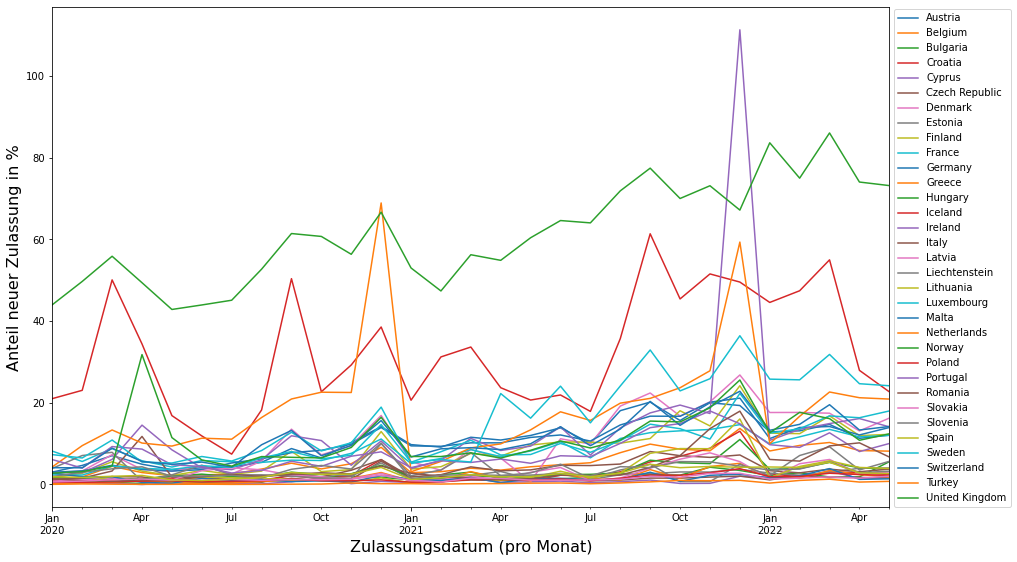

In [7]:
# Visualization of the input data
df.plot(figsize=(15,9.2))
#plt.title('Neu Zulassung BEV-PKWs in 33 Ländern', size=22)
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=3, bbox_to_anchor=(1.0,-0.01))
plt.show()

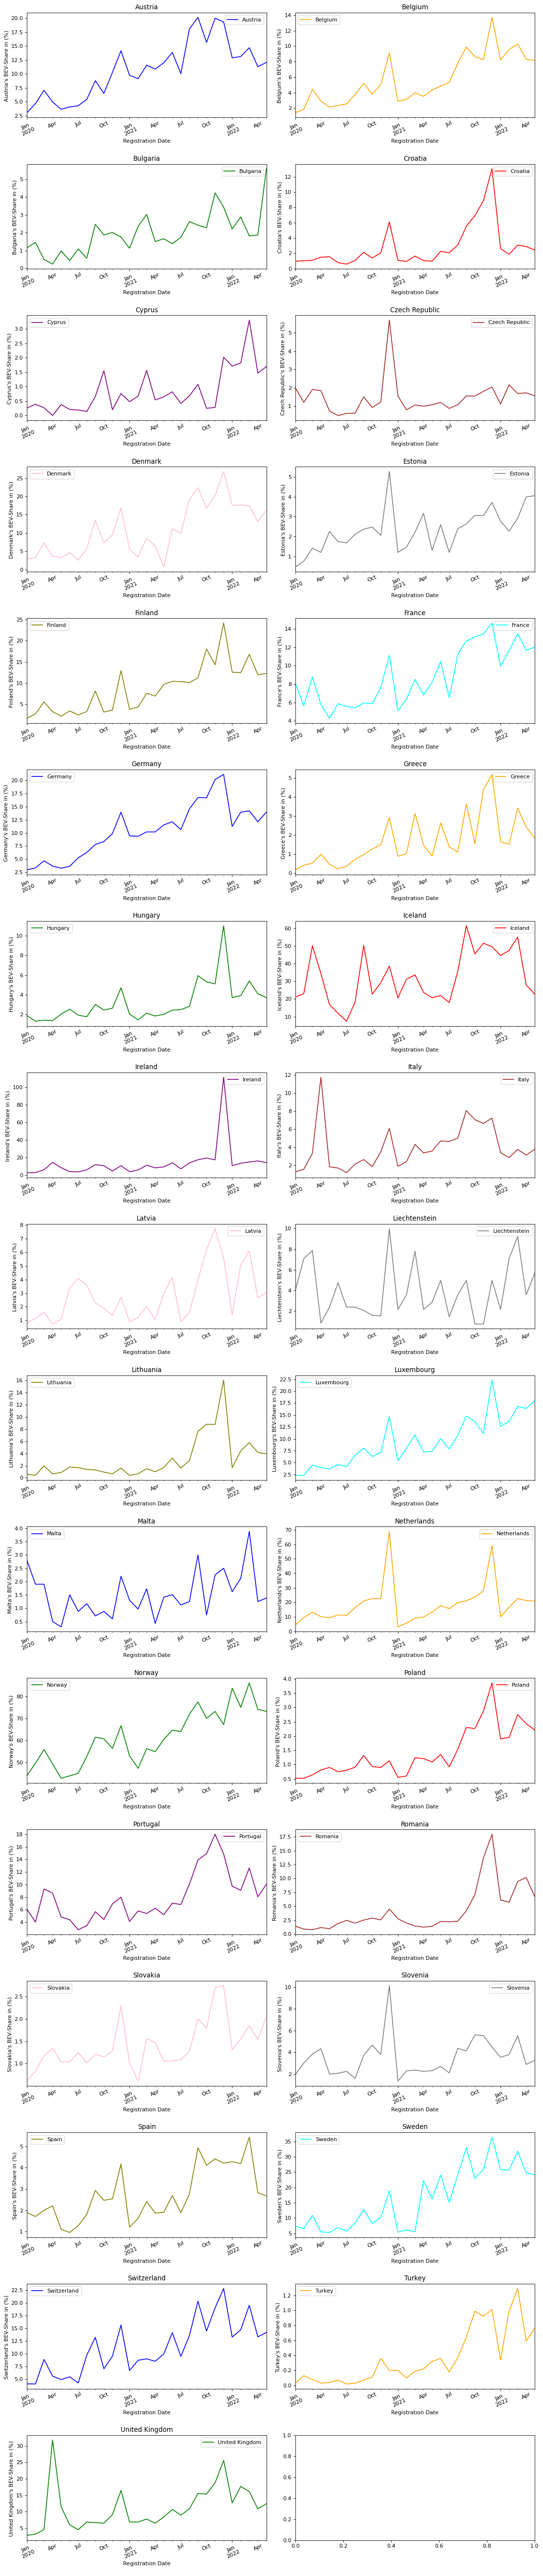

In [8]:
# Visualisation of dataset per variable on a seperate plot.
# Defining type of colors for variables
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.set_xlabel("Registration Date\n".format(key)), 
        ax.set_ylabel("{}'s BEV-Share in (%) ".format(key)), 
        ax.legend([key])
    plt.tight_layout()


Visualize(df)

## Handling Outlier:

In [9]:
# There is an outlier in Variable "Ireland". Thus, it needs to be handeld.
# Replacing the outlier with: Nov. 2022 + Jan. 2023 (devided by 2)
Irland_Okt_22_Jan2023_Mean = (df["Ireland"]["2021-11-01"] + df["Ireland"]["2022-01-01"])/2
df["Ireland"]["2021-12-01"] = round(Irland_Okt_22_Jan2023_Mean, 2)    

In [10]:
# Deleting any country that has a mean value of less than target variable's lowest values.
# Because Germany's (target value) minimum value is 2.98 (rounded to be 3), therefore,
# Any country that has a mean value lower than 3 is deleted.
# This because those variables won't contribute significantly to accuratle predict the target value.
min_values_germany = 3
country_names_above_required_value = []
for col in df.columns:
    if df[col].mean(axis=0)>min_values_germany:
        country_names_above_required_value.append(col)


country_names_above_required_value

['Austria',
 'Belgium',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Netherlands',
 'Norway',
 'Portugal',
 'Romania',
 'Slovenia',
 'Sweden',
 'Switzerland',
 'United Kingdom']

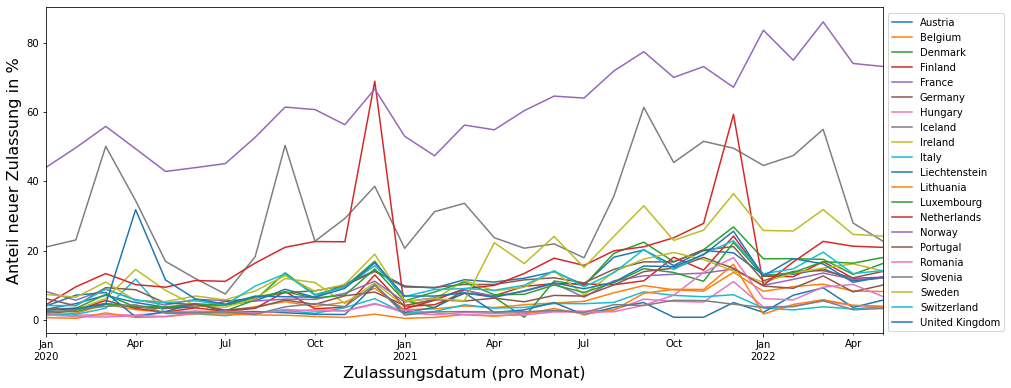

In [11]:
# Visualising the new processed input data (after outlier and preprocessing in EDA)
df = df[country_names_above_required_value]
df.plot(figsize=(15,6))
#plt.title('Neu Zulassung BEV-PKWs in 33 Ländern', size=22)
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=3, bbox_to_anchor=(1.0,-0.01))
plt.show()

In [12]:
# Checking the input data again
df.head(7)

Austria  Belgium  Denmark  Finland  France  Germany  Hungary  \
datum                                                                      
2020-01-01     3.03     1.41     2.83     1.67    8.16     2.98     1.88   
2020-02-01     4.66     1.85     3.28     2.74    5.63     3.34     1.30   
2020-03-01     7.06     4.44     7.30     5.56    8.79     4.69     1.41   
2020-04-01     4.96     2.91     3.65     3.26    5.80     3.69     1.36   
2020-05-01     3.64     2.14     3.23     2.19    4.27     3.28     2.02   
2020-06-01     4.07     2.34     4.61     3.42    5.87     3.63     2.53   
2020-07-01     4.29     2.55     2.55     2.48    5.56     5.26     1.92   

            Iceland  Ireland  Italy  ...  Lithuania  Luxembourg  Netherlands  \
datum                                ...                                       
2020-01-01    21.02     2.88   1.25  ...       0.61        2.36         4.31   
2020-02-01    23.05     2.89   1.55  ...       0.40        2.31         9.51   
2020-03-01    50.09     6.14   3.30  ...       1.97        4.50        13.34   
2020-04-01    34.41    14.53  11.76  ...       0.65        3.94        10.14   
2020-05-01    16.86     8.48   1.82  ...       0.88        3.68         9.40   
2020-06-01    11.89     4.06   1.68  ...       1.76        4.60        11.33   
2020-07-01     7.43     3.63   1.17  ...       1.67        4.19        11.09   

            Norway  Portugal  Romania  Slovenia  Sweden  Switzerland  \
datum                                                                  
2020-01-01   44.01      6.09     1.41      1.93    7.31         4.10   
2020-02-01   49.71      4.02     0.89      3.01    6.49         4.08   
2020-03-01   55.88      9.28     0.78      3.83   10.88         8.89   
2020-04-01   49.40      8.66     1.16      4.33    5.50         5.62   
2020-05-01   42.85      4.82     0.96      1.99    5.25         4.93   
2020-06-01   43.95      4.40     1.89      2.06    6.85         5.48   
2020-07-01   45.11      2.81     2.46      2.24    5.74         4.27   

            United Kingdom  
datum                       
2020-01-01            2.78  
2020-02-01            3.15  
2020-03-01            4.54  
2020-04-01           31.80  
2020-05-01           11.48  
2020-06-01            6.00  
2020-07-01            4.50  

[7 rows x 21 columns]

In [13]:
df.describe()

Austria    Belgium    Denmark    Finland     France    Germany  \
count  29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean   10.740000   5.702759  10.817586   8.602759   8.828276  10.390000   
std     5.045019   3.145111   7.064752   5.594323   3.116901   5.011553   
min     3.030000   1.410000   0.710000   1.670000   4.270000   2.980000   
25%     6.490000   3.130000   4.610000   3.420000   5.870000   6.280000   
50%    10.880000   4.840000   9.520000   8.120000   8.200000  10.190000   
75%    13.860000   8.250000  16.900000  12.270000  11.660000  13.950000   
max    20.170000  13.710000  26.810000  24.180000  14.650000  21.140000   

         Hungary    Iceland    Ireland      Italy  ...  Lithuania  Luxembourg  \
count  29.000000  29.000000  29.000000  29.000000  ...  29.000000   29.000000   
mean    3.180690  32.235172  10.293793   3.941034  ...   3.029655    9.478966   
std     2.020735  14.443505   4.882091   2.408453  ...   3.475084    5.151469   
min     1.300000   7.430000   2.880000   1.170000  ...   0.390000    2.310000   
25%     1.920000  21.020000   6.050000   2.120000  ...   0.940000    5.440000   
50%     2.480000  29.260000  10.750000   3.380000  ...   1.650000    8.020000   
75%     3.910000  45.430000  14.110000   4.690000  ...   3.920000   13.640000   
max    11.020000  61.380000  19.440000  11.760000  ...  16.040000   22.310000   

       Netherlands     Norway   Portugal    Romania   Slovenia     Sweden  \
count    29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean     18.561379  61.415862   7.945517   4.158621   3.506207  16.394138   
std      14.209325  12.265003   3.851911   4.125133   1.763668   9.815321   
min       3.110000  42.850000   2.810000   0.780000   1.340000   5.250000   
25%       9.970000  52.710000   5.190000   1.450000   2.240000   6.850000   
50%      16.390000  60.730000   6.920000   2.460000   3.260000  15.090000   
75%      21.240000  71.890000   9.740000   5.720000   4.330000  24.170000   
max      68.930000  86.070000  18.000000  17.950000  10.140000  36.420000   

       Switzerland  United Kingdom  
count    29.000000       29.000000  
mean     11.185862       11.078966  
std       5.177386        6.614706  
min       4.080000        2.780000  
25%       7.030000        6.650000  
50%       9.720000        9.060000  
75%      14.200000       15.320000  
max      22.820000       31.800000  

[8 rows x 21 columns]

## Correltaion check:

### Spearman’s Rank Correlation
This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. 


The function takes two real-valued samples as arguments and returns both the correlation coefficient in the range between -1 and 1 and the p-value for interpreting the significance of the coefficient.

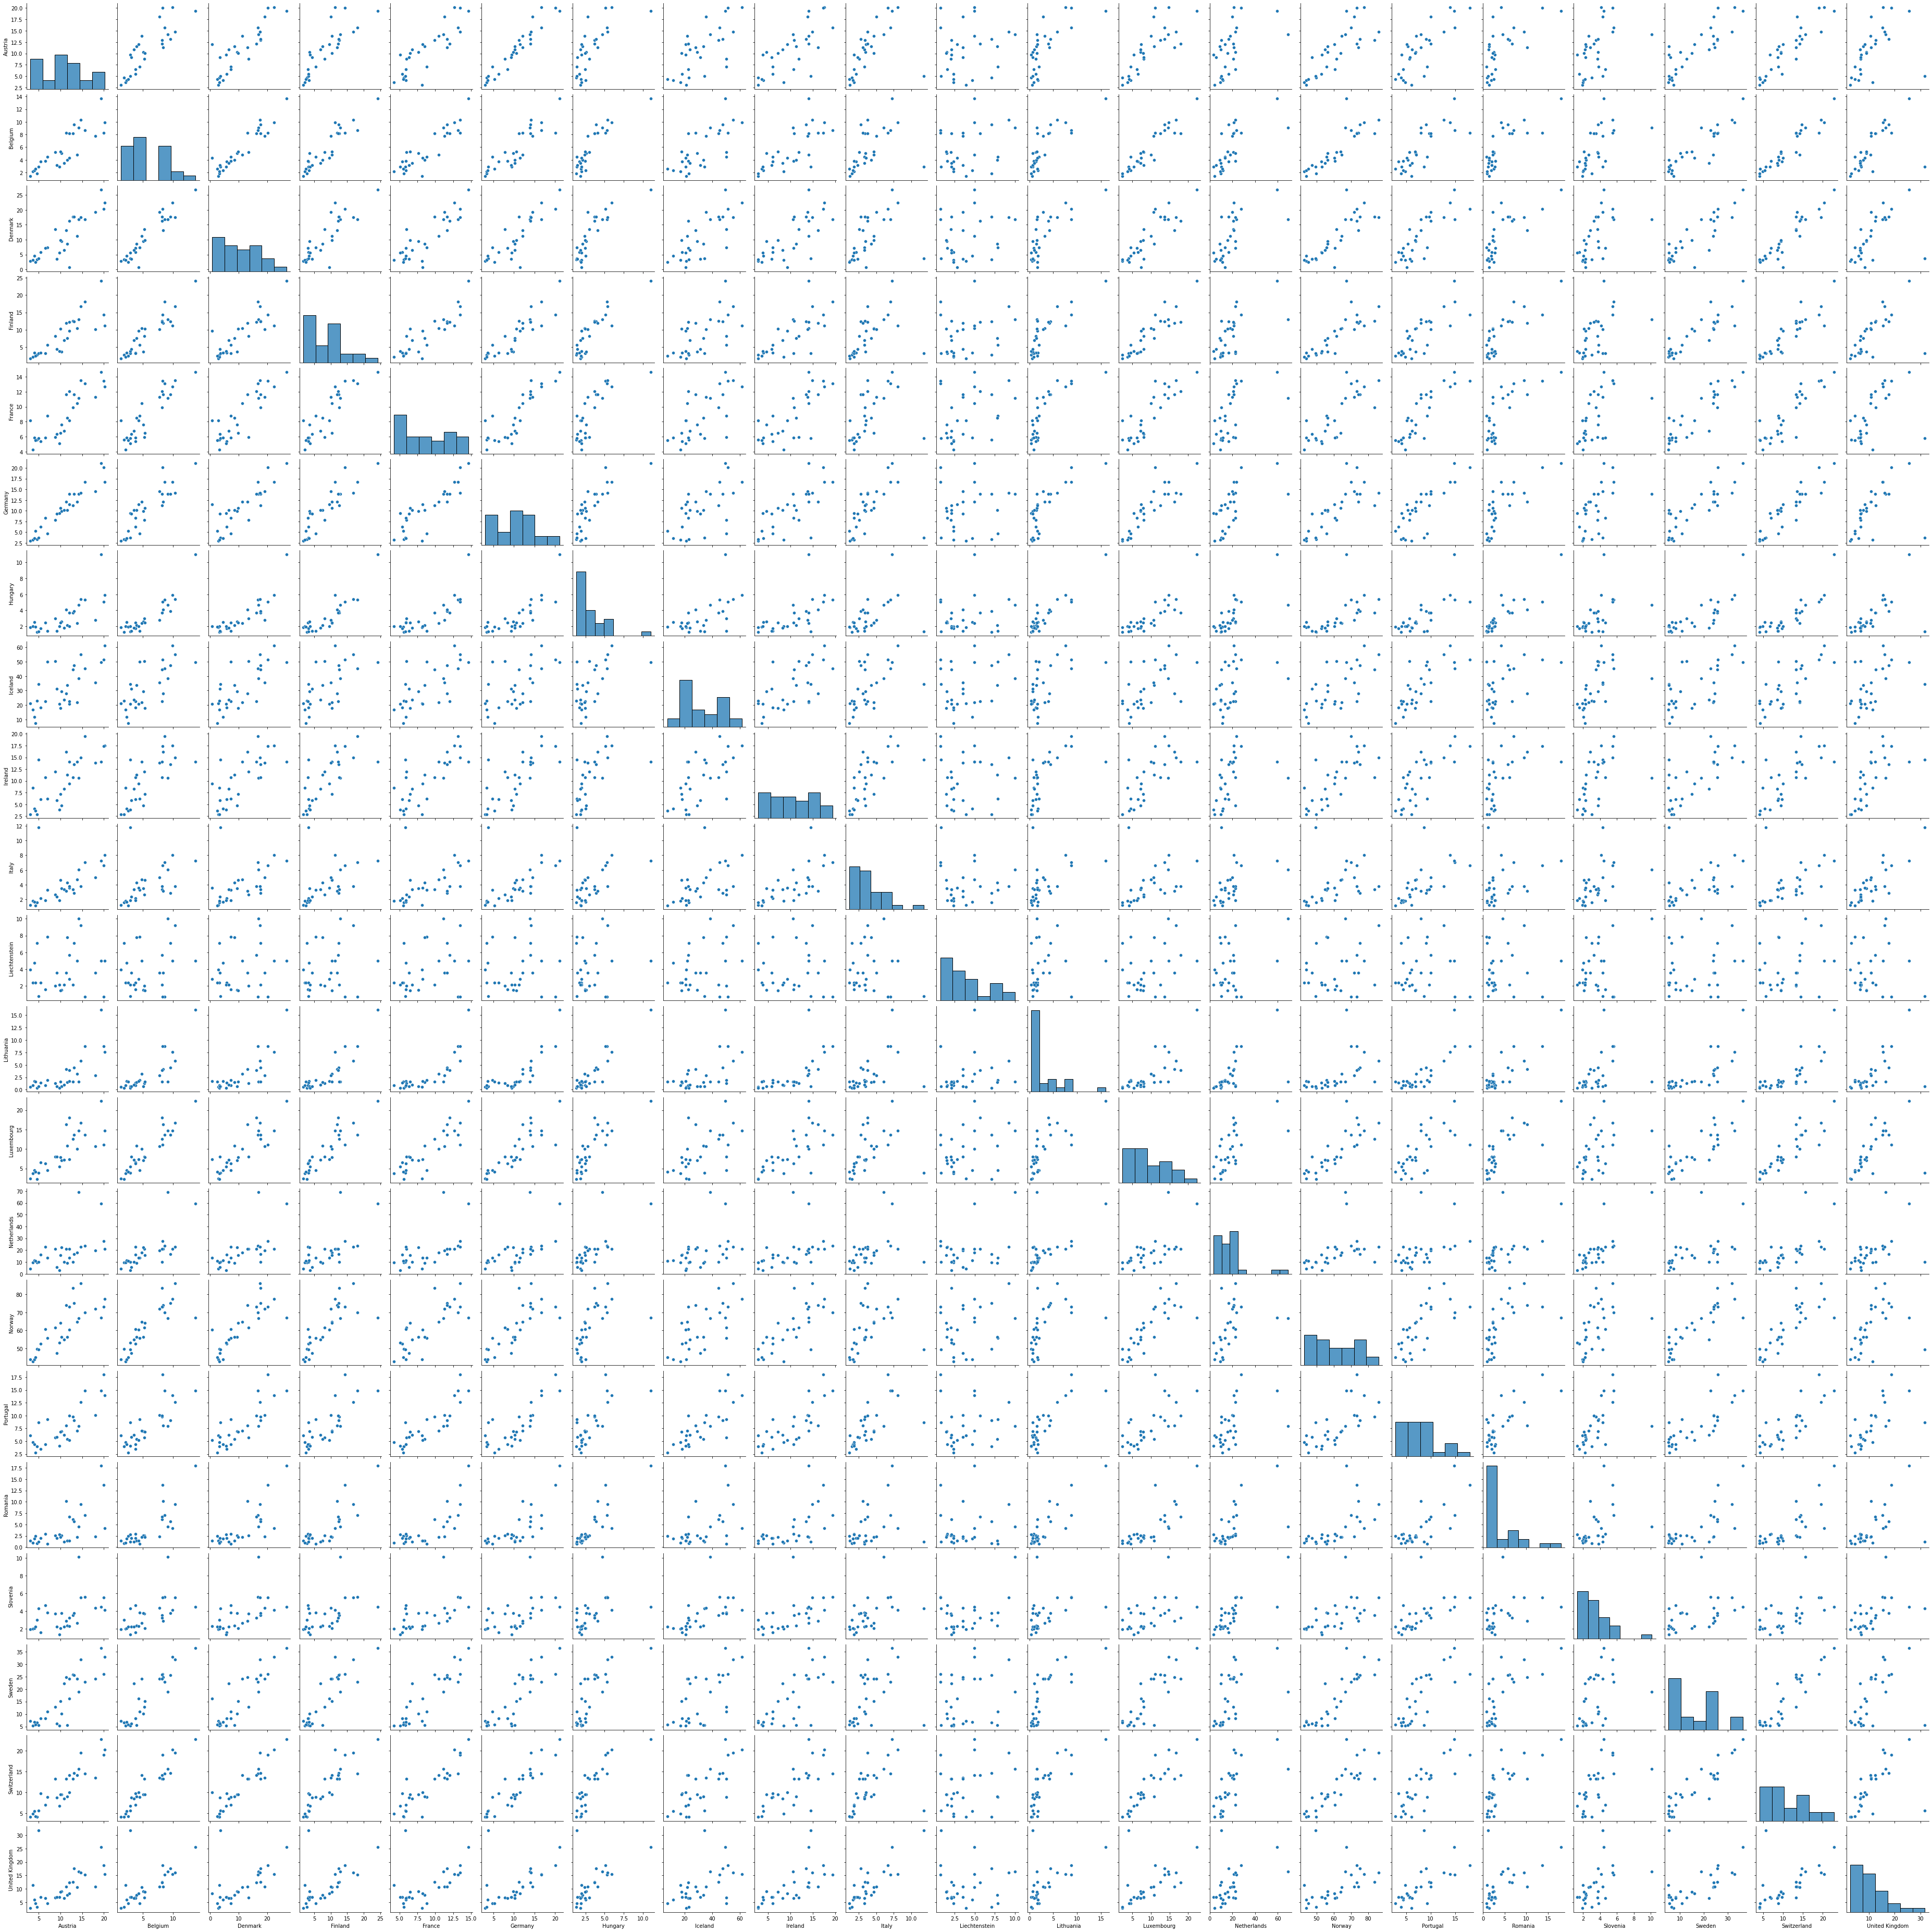

In [14]:
# Visualisation of pairplot
sns.pairplot(df)

Piar Plot doesn't look very intuitive due to small size of plots.

Thus, the correlation plots will help understand the correlation of market-share (%) BEV-PKW new registration in Germany against other 32 countries.

In [15]:
# Spearman’s Rank Correlation
df_corr=df.corr(method='spearman')
df_corr

Austria   Belgium   Denmark   Finland    France   Germany  \
Austria         1.000000  0.875862  0.851232  0.902463  0.864252  0.973146   
Belgium         0.875862  1.000000  0.908374  0.923645  0.863760  0.894063   
Denmark         0.851232  0.908374  1.000000  0.846798  0.806356  0.839123   
Finland         0.902463  0.923645  0.846798  1.000000  0.875339  0.911555   
France          0.864252  0.863760  0.806356  0.875339  1.000000  0.867053   
Germany         0.973146  0.894063  0.839123  0.911555  0.867053  1.000000   
Hungary         0.764474  0.867209  0.850209  0.813994  0.772302  0.811114   
Iceland         0.655665  0.713300  0.740887  0.638916  0.691796  0.569845   
Ireland         0.741224  0.751078  0.720532  0.732849  0.729826  0.750154   
Italy           0.783251  0.687685  0.660591  0.701478  0.669869  0.737127   
Liechtenstein   0.149346  0.174772  0.131326  0.165639  0.311976  0.097655   
Lithuania       0.737127  0.780981  0.706578  0.792313  0.829226  0.788073   
Luxembourg      0.866010  0.914778  0.835468  0.921182  0.851441  0.902439   
Netherlands     0.637438  0.789163  0.704926  0.660099  0.655087  0.686869   
Norway          0.854680  0.922660  0.876355  0.870936  0.827297  0.863760   
Portugal        0.788177  0.801478  0.813300  0.794089  0.887164  0.769894   
Romania         0.684236  0.787685  0.756650  0.754187  0.678246  0.770880   
Slovenia        0.633900  0.698694  0.678739  0.600887  0.660917  0.594998   
Sweden          0.829412  0.876709  0.838773  0.851829  0.876925  0.846741   
Switzerland     0.919212  0.954680  0.885714  0.920197  0.865731  0.921656   
United Kingdom  0.709360  0.729557  0.687192  0.711330  0.620103  0.713476   

                 Hungary   Iceland   Ireland     Italy  ...  Lithuania  \
Austria         0.764474  0.655665  0.741224  0.783251  ...   0.737127   
Belgium         0.867209  0.713300  0.751078  0.687685  ...   0.780981   
Denmark         0.850209  0.740887  0.720532  0.660591  ...   0.706578   
Finland         0.813994  0.638916  0.732849  0.701478  ...   0.792313   
France          0.772302  0.691796  0.729826  0.669869  ...   0.829226   
Germany         0.811114  0.569845  0.750154  0.737127  ...   0.788073   
Hungary         1.000000  0.541513  0.680424  0.515398  ...   0.736570   
Iceland         0.541513  1.000000  0.631851  0.574877  ...   0.473762   
Ireland         0.680424  0.631851  1.000000  0.756004  ...   0.717753   
Italy           0.515398  0.574877  0.756004  1.000000  ...   0.536093   
Liechtenstein   0.079259  0.169835 -0.029873 -0.038262  ...   0.233087   
Lithuania       0.736570  0.473762  0.717753  0.536093  ...   1.000000   
Luxembourg      0.844050  0.584236  0.746151  0.630542  ...   0.751663   
Netherlands     0.767430  0.505911  0.630127  0.542857  ...   0.656073   
Norway          0.806110  0.650739  0.756251  0.591133  ...   0.712244   
Portugal        0.680463  0.761576  0.773248  0.775369  ...   0.709781   
Romania         0.877556  0.452709  0.593423  0.376847  ...   0.627248   
Slovenia        0.587482  0.787632  0.659603  0.635132  ...   0.502957   
Sweden          0.770235  0.614608  0.675782  0.563863  ...   0.804608   
Switzerland     0.837398  0.674877  0.771277  0.717734  ...   0.799212   
United Kingdom  0.668391  0.539901  0.773002  0.770443  ...   0.541759   

                Luxembourg  Netherlands    Norway  Portugal   Romania  \
Austria           0.866010     0.637438  0.854680  0.788177  0.684236   
Belgium           0.914778     0.789163  0.922660  0.801478  0.787685   
Denmark           0.835468     0.704926  0.876355  0.813300  0.756650   
Finland           0.921182     0.660099  0.870936  0.794089  0.754187   
France            0.851441     0.655087  0.827297  0.887164  0.678246   
Germany           0.902439     0.686869  0.863760  0.769894  0.770880   
Hungary           0.844050     0.767430  0.806110  0.680463  0.877556   
Iceland           0.584236     0.505911  0.650739  0.761576  0.452709   
Ireland       

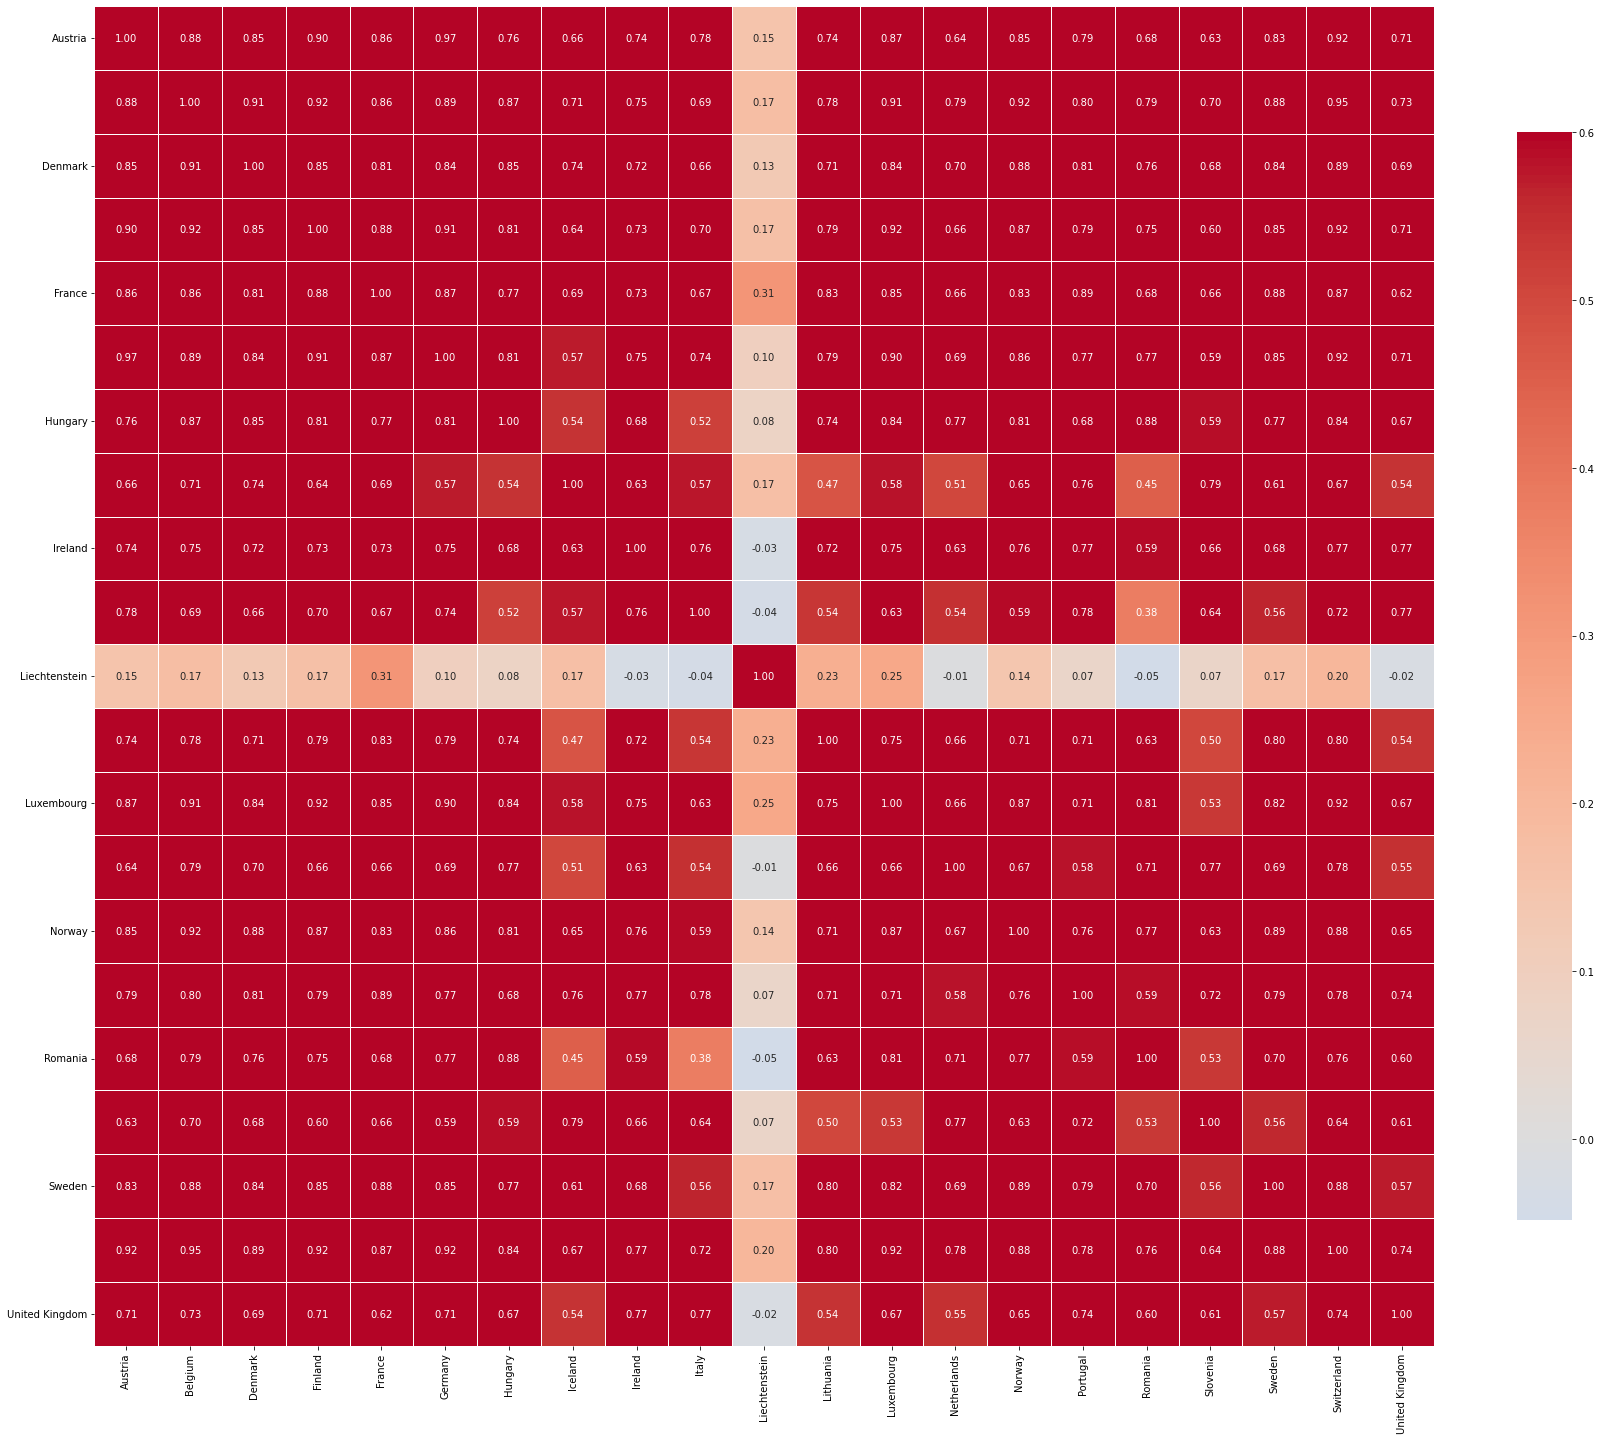

In [16]:
# Visualiziatioin of Spearman's Rank Correlation in a heatmap plot
heat_map = sns.heatmap(df_corr,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')

heat_map.figure.set_size_inches(30,40)
plt.show()

After handling outlier and all countries that has less mean values than Germany's minimum values, we can see that:

Germany has a positive correlation with all the remaining 21 Countries, which is above 50% (except for Liechtenstein 10%). 

# Train Test Split
* Training set:  80%  = 23 Monaten
* Test set:      20% = 6  Monaten

### Transposing Dataset 

To prepare the dataset we need to transpose the dataset (Columns become rows and rows become columns). This way, we delete the index/date column. As a result, we have values of 33 countries as rows and coutry names as a single column (new converted index-column).

Note: We will add the date during later in Train-Test-Split, as any forecasting modell depends on a dataset with time frequency (No worries!).

In [14]:
# Transposing the input data
df_input=df.reset_index(drop=True).T.reset_index()
df_input

index      0      1      2      3      4      5      6      7  \
0          Austria   3.03   4.66   7.06   4.96   3.64   4.07   4.29   5.42   
1          Belgium   1.41   1.85   4.44   2.91   2.14   2.34   2.55   3.77   
2          Denmark   2.83   3.28   7.30   3.65   3.23   4.61   2.55   5.74   
3          Finland   1.67   2.74   5.56   3.26   2.19   3.42   2.48   3.28   
4           France   8.16   5.63   8.79   5.80   4.27   5.87   5.56   5.40   
5          Germany   2.98   3.34   4.69   3.69   3.28   3.63   5.26   6.28   
6          Hungary   1.88   1.30   1.41   1.36   2.02   2.53   1.92   1.75   
7          Iceland  21.02  23.05  50.09  34.41  16.86  11.89   7.43  18.24   
8          Ireland   2.88   2.89   6.14  14.53   8.48   4.06   3.63   6.05   
9            Italy   1.25   1.55   3.30  11.76   1.82   1.68   1.17   2.12   
10   Liechtenstein   3.94   7.09   7.87   0.79   2.36   4.72   2.36   2.36   
11       Lithuania   0.61   0.40   1.97   0.65   0.88   1.76   1.67   1.38   
12      Luxembourg   2.36   2.31   4.50   3.94   3.68   4.60   4.19   6.54   
13     Netherlands   4.31   9.51  13.34  10.14   9.40  11.33  11.09  16.39   
14          Norway  44.01  49.71  55.88  49.40  42.85  43.95  45.11  52.71   
15        Portugal   6.09   4.02   9.28   8.66   4.82   4.40   2.81   3.45   
16         Romania   1.41   0.89   0.78   1.16   0.96   1.89   2.46   1.96   
17        Slovenia   1.93   3.01   3.83   4.33   1.99   2.06   2.24   1.58   
18          Sweden   7.31   6.49  10.88   5.50   5.25   6.85   5.74   8.30   
19     Switzerland   4.10   4.08   8.89   5.62   4.93   5.48   4.27   9.72   
20  United Kingdom   2.78   3.15   4.54  31.80  11.48   6.00   4.50   6.83   

        8  ...     19     20     21     22     23     24     25     26     27  \
0    8.79  ...  18.07  20.17  15.66  20.01  19.33  12.89  13.13  14.71  11.30   
1    5.21  ...   7.78   9.88   8.64   8.25  13.71   8.20   9.56  10.28   8.30   
2   13.54  ...  19.19  22.40  16.75  20.23  26.81  17.62  17.64  17.45  13.11   
3    8.12  ...  10.11  11.25  18.05  14.33  24.18  12.57  12.44  16.79  11.96   
4    5.95  ...  11.26  12.69  13.13  13.46  14.65   9.93  11.66  13.49  11.66   
5    7.80  ...  14.57  16.72  16.70  20.15  21.14  11.24  13.95  14.19  12.13   
6    3.00  ...   2.81   5.94   5.31   5.10  11.02   3.70   3.91   5.40   4.10   
7   50.39  ...  35.71  61.38  45.43  51.55  49.56  44.57  47.43  55.00  27.94   
8   11.92  ...  13.85  17.52  19.44  17.38  14.08  10.79  13.50  14.91  16.14   
9    2.62  ...   5.00   8.06   7.05   6.63   7.22   3.38   2.84   3.75   3.12   
10   2.03  ...   3.55   4.96   0.71   0.71   4.96   2.13   7.09   9.22   3.55   
11   1.30  ...   2.83   7.62   8.79   8.75  16.04   1.65   4.41   5.79   4.17   
12   8.05  ...  10.71  14.76  13.65  11.11  22.31  12.58  13.64  16.78  16.34   
13  20.93  ...  19.91  21.08  23.68  27.84  59.35   9.97  16.69  22.64  21.24   
14  61.44  ...  71.89  77.45  70.02  73.14  67.18  83.66  75.00  86.07  74.05   
15   5.68  ...  10.06  13.91  14.91  18.00  14.86   9.74   9.08  12.65   8.05   
16   2.51  ...   2.30   4.19   7.07  13.68  17.95   6.13   5.72   9.44  10.19   
17   3.72  ...   4.36   4.12   5.61   5.53   4.48   3.54   3.78   5.53   2.88   
18  12.78  ...  24.11  32.93  22.91  25.89  36.42  25.79  25.62  31.84  24.67   
19  13.24  ...  13.57  20.33  14.48  19.02  22.82  13.27  14.72  19.53  13.33   
20   6.65  ...  10.86  15.52  15.32  18.77  25.58  12.65  17.66  16.12  10.82   

       28  
0   12.07  
1    8.16  
2   16.25  
3   12.27  
4   12.03  
5   13.95  
6    3.70  
7   22.68  
8   14.11  
9    3.76  
10   5.67  
11   3.92  
12  18.00  
13  20.91  
14  73.18  
15  10.03  
16   6.72  
17   3.26  
18  24.17  
19  14.20  
20  12.40  

[21 rows x 30 columns]

To generate a global model, we need to tell the model that each country (time series) has to be treated as seperate model internally. For this, we need need to add additional Information to the model as below:

(converting strings to numeric value -> then to to columns)

In [15]:
# Creating a categorical code for each country
country_code=df_input["index"].astype('category').cat.codes.values
country_code

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int8)

As shown  above there are 21 values (from 0 to 20), that conresponds to the number of countries specified above.

In [16]:
# Taking the first 23 columns (originally as rows in input-dataset) for training and the last 6 values for testing purposes.
df_train=df_input.iloc[:,1:24].values
df_test=df_input.iloc[:,24:].values

In [17]:
# Checking shape of training-dataset
df_train.shape

(21, 23)

In [18]:
# Checking shape of test-dataset
df_test.shape

(21, 6)

#### Finalising the Train-Test-Split Process

We will conclude the training and test-dataset with all the required ingriedients, but for DeepAR-Model (GluonTS)

In [19]:
freq = "M"                              # Data frequency – "M" means monthly dataset
prediction_length = 6                   # Number of future values to be forecasted. It's the prediction length of time series – This can not be changed once the model is trained

start_train = pd.Timestamp("2020-01-01", freq=freq)     # Starting date of the training-dataset
#start_test = pd.Timestamp("2021-11-01", freq=freq)      # Starting date of the test-dataset


# Creating the Training Dataset
training_data = ListDataset([
    {
        FieldName.TARGET: target,       # Data values of countries (time series) for Training
        FieldName.START: start_train,   # Starting Date in Training Dataset
        FieldName.FEAT_STATIC_CAT: fsc, # categorical values (country codes)
    }
    for (target, fsc) in zip(df_train,
                             country_code.reshape(-1,1))
], freq=freq)                           # Data Frequency – For Monthly Data it is always "M"

# Creating Test Dataset
test_data = ListDataset([
    {
        FieldName.TARGET: target,       # Data values of countries (time series) for Testing
        FieldName.START: start_train,   # Starting Date in Test-Dataset
        FieldName.FEAT_STATIC_CAT: fsc  # categorical values (country codes) 
    }
    for (target, fsc) in zip(df_input.iloc[:,1:].values,
                            country_code.reshape(-1,1))
], freq=freq)


In [20]:
# Checking values in Training Dataset
train_entry = next(iter(training_data))
train_entry

{'target': array([ 3.03,  4.66,  7.06,  4.96,  3.64,  4.07,  4.29,  5.42,  8.79,
         6.49, 10.28, 14.16,  9.76,  9.15, 11.56, 10.88, 12.  , 13.86,
        10.06, 18.07, 20.17, 15.66, 20.01], dtype=float32),
 'start': Period('2020-01', 'M'),
 'feat_static_cat': array([0], dtype=int32)}

In [21]:
# Checking Test Dataset's values
# Iterating the Test Dataset
test_entry = next(iter(test_data))
# Shows the keys for the values
test_entry

{'target': array([ 3.03,  4.66,  7.06,  4.96,  3.64,  4.07,  4.29,  5.42,  8.79,
         6.49, 10.28, 14.16,  9.76,  9.15, 11.56, 10.88, 12.  , 13.86,
        10.06, 18.07, 20.17, 15.66, 20.01, 19.33, 12.89, 13.13, 14.71,
        11.3 , 12.07], dtype=float32),
 'start': Period('2020-01', 'M'),
 'feat_static_cat': array([0], dtype=int32)}

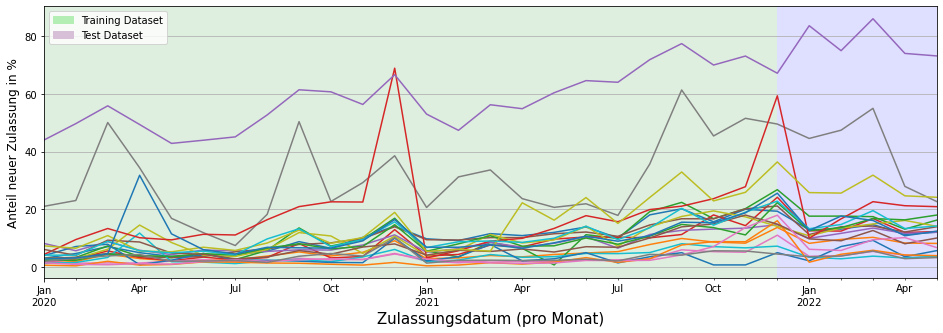

In [22]:
# Visualisation of Train-Test-Split in one Plot: Method 1
# Visualize Train Test Split Datasets
train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots()

df.plot(ax=ax,figsize=(16,5))
#ax.axvline(df_train.index[-1], color="r")  # End of Training dataset
plt.axvspan(train_series.index[0] , test_series.index[-6], facecolor="green", alpha=0.125)
plt.axvspan(test_series.index[-6], test_series.index[-1], facecolor="blue", alpha=0.125)
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=15)
plt.ylabel('Anteil neuer Zulassung in %' ,size=12)

# Creating legend with color box
import matplotlib.patches as mpatches
leg_col_training_dataset = mpatches.Patch(color='#B4EEB4', label="Training Dataset")
leg_col_test_dataset = mpatches.Patch(color='thistle', label="Test Dataset")

ax.legend(loc="upper left", handles=[leg_col_training_dataset, leg_col_test_dataset])
plt.grid(axis = 'y')
plt.show()

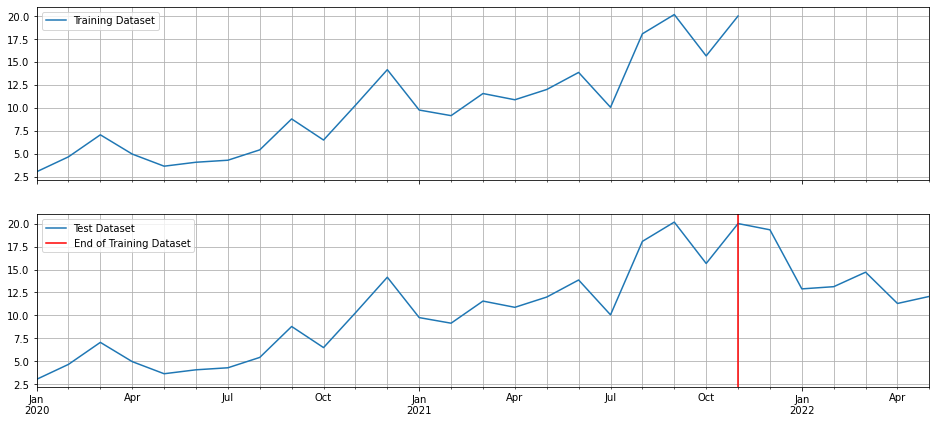

In [23]:
# Visualize Train Test Split Datasets: Method 2
train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["Training Dataset"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # End of Training dataset
ax[1].grid(which="both")
ax[1].legend(["Test Dataset", "End of Training Dataset"], loc="upper left")

plt.show()

# DeepAR: Model Training

In [ ]:
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values
context_length = 19             
prediction_length = 6          
freq = "M"

estimator = DeepAREstimator(context_length=context_length,                # Length of Data to used for training before prediction
                            freq = freq,                                  # Data frequency
                            prediction_length = prediction_length,        # Length of time points to be predicted
                            use_feat_static_cat=True,                     # We must tell the model that we have many variables e.g. country. "True" means many variables exist.
                            cardinality=[1],                              # We need to specify how many categorical variables we have. 1 means that we have only one column of categorical variables
                            num_layers = 23,                              # Number of Layers in RNN
                            num_cells = 2,                                # Number of Cells in RNN
                            cell_type = "lstm",                           # Type of Cell in RNN
                            dropout_rate = 0.1122435424261366,                      # Dropout rate between layers to avoid overfitting
                            trainer = Trainer(
                                epochs = 50,                              # Num of Epochs
                                batch_size = 10,                          # Num of batch size
                                num_batches_per_epoch = 14,               # Num of batches per epochs in total
                                learning_rate = 0.09685043383629997)                 # learning rate for model's internal parameters and error-update
                            )

# Execution of DeepAR Model Training
predictor = estimator.train(training_data=training_data,num_workers=None) # Setting num of CPUs to 1 to avoid getting different prediction values 

# Model Evaluation
We need to specify the test dataset to achieve a model-error-metric.

In [60]:
# First creating the forecasts
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data,       # Test dataset
                                                 predictor = predictor,     # Predictor/Fitted Model
                                                 num_samples = 100          # Number of sample paths we want for evaluation
                                                 )

# First, we can convert these generators to lists to ease further computations.
forecasts = list(forecast_it)   # Forecasted Values
tss = list(ts_it)               # Time Series Data

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let’s start with the list containing the time series, i.e., tss. We expect the first entry of tss to contain the (target of the) first time series of test_dataset.

In [61]:
# 5. entry of the time series list (6. is Germany in our dataset)
ts_entry = tss[5]
ts_entry

0
2020-01   2.980000
2020-02   3.340000
2020-03   4.690000
2020-04   3.690000
2020-05   3.280000
2020-06   3.630000
2020-07   5.260000
2020-08   6.280000
2020-09   7.800000
2020-10   8.360000
2020-11   9.870000
2020-12  13.940000
2021-01   9.450000
2021-02   9.350000
2021-03  10.190000
2021-04  10.190000
2021-05  11.520000
2021-06  12.120000
2021-07  10.630000
2021-08  14.570000
2021-09  16.719999
2021-10  16.700001
2021-11  20.150000
2021-12  21.139999
2022-01  11.240000
2022-02  13.950000
2022-03  14.190000
2022-04  12.130000
2022-05  13.950000

In [62]:
# first entry of the forecast list
# (6. is Germany in our dataset)
forecast_entry = forecasts[5]
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=numpy.array([[13.928003311157227, 10.998265266418457, 12.850495338439941, 13.0020112991333, 12.111776351928711, 14.52529525756836], [21.504770278930664, 10.760848999023438, 9.89969539642334, 9.591647148132324, 12.574212074279785, 21.707504272460938], [30.540555953979492, 16.54347038269043, 15.416744232177734, 17.52128791809082, 12.14259147644043, 11.997025489807129], [34.98474884033203, 16.781681060791016, 20.288856506347656, 10.128302574157715, 11.650276184082031, 27.719724655151367], [18.92856216430664, 9.410914421081543, 12.568323135375977, 14.048395156860352, 13.725241661071777, 16.116331100463867], [23.7490177154541, 12.397963523864746, 12.560458183288574, 16.648035049438477, 21.048568725585938, 25.50543785095215], [10.89522933959961, 8.32247257232666, 9.927332878112793, 8.793671607971191, 6.539613246917725, 11.963078498840332], [30.651626586914062, 12.898382186889648, 11.614958763122559, 12.871050834655762, 12

The entries in the forecast list are a bit more complex. They are objects that contain all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [63]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 6)
Start date of the forecast window: 2021-12
Frequency of the time series: <MonthEnd>


### Forecast Visualisation (1):
Without confidence interval

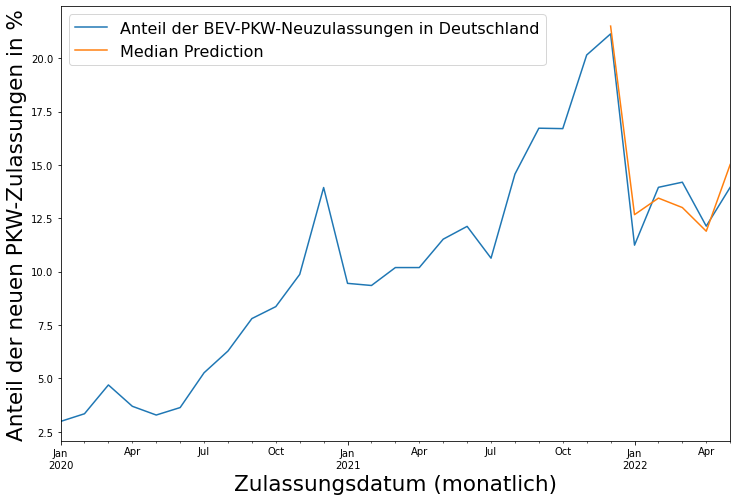

In [64]:
# Method 1: To visualize the forecasted values vs. observation/actual values (point forecast).
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                                                   # Maximum num of time points to plot. e.g. 66 time points (months)
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"]      # Label for legends in plots
    Forecast_Median = pd.DataFrame(forecast_entry.median, index=ts_entry[-6:].index)    # Creating a DataFrame with forecast median

    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry.plot(ax=ax)  # plot the time series
    Forecast_Median.plot(ax=ax)
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")

for i in range(21):
    # Germany is number 6 on the list. 
    # Thus, we write 5 due to Python indexing to get values for Germany 
    if i==5:
        plot_prob_forecasts(tss[i], forecasts[i])

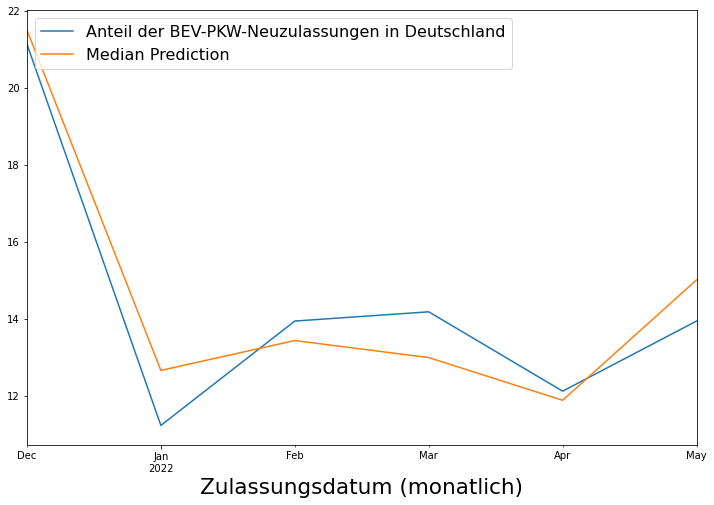

In [65]:
# Method 1: To visualize the forecasted values vs. observation/actual values (point forecast).
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                                                   # Maximum num of time points to plot. e.g. 66 time points (months)
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"]      # Label for legends in plots
    Forecast_Median = pd.DataFrame(forecast_entry.median, index=ts_entry[-6:].index)    # Creating a DataFrame with forecast median

    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry[-prediction_length:].plot(ax=ax)  # plot the time series
    Forecast_Median.plot(ax=ax)
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    #plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")

# We already defined "ts_entry = tss[5]" and "forecast_entry = forecasts[5]"
# This mean, we have the values for Germany sepecified already.
plot_prob_forecasts(ts_entry, forecast_entry)
#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])      # In case if we set a 2nd Time step for evaluation in test_data

### Forecast Visualisation (2):
With Confidence Interval

Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.

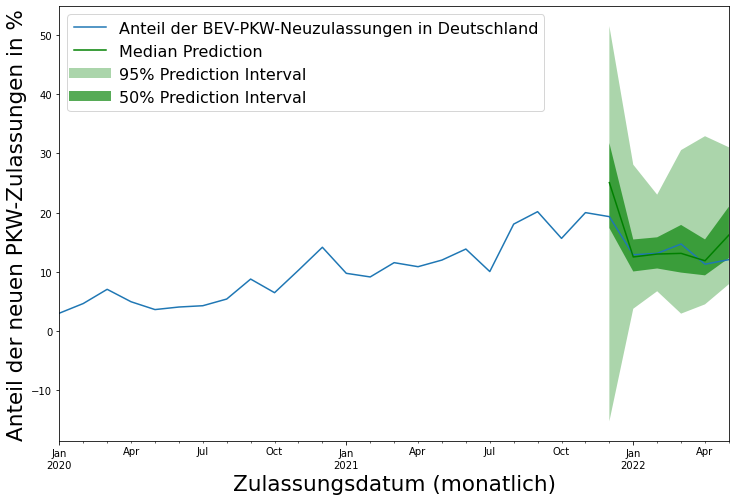

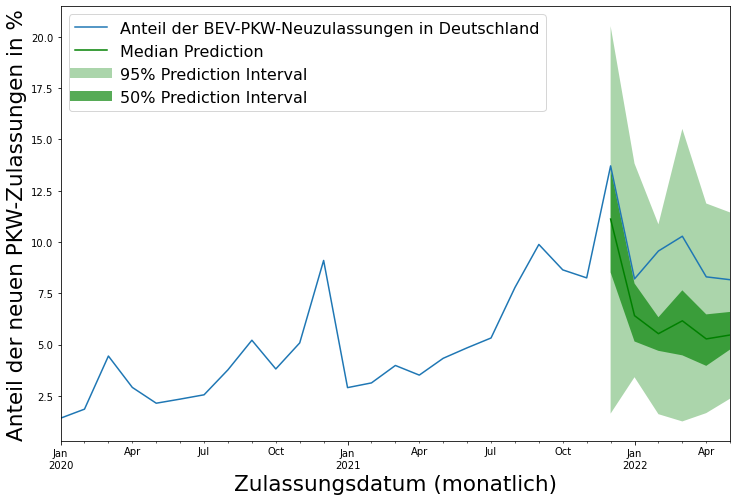

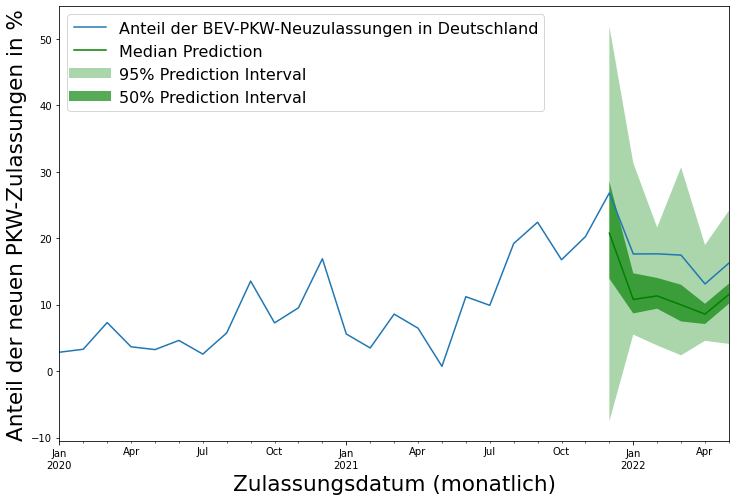

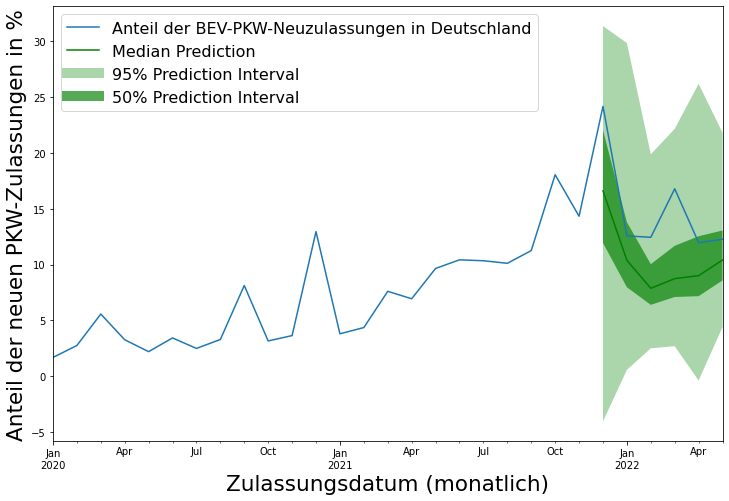

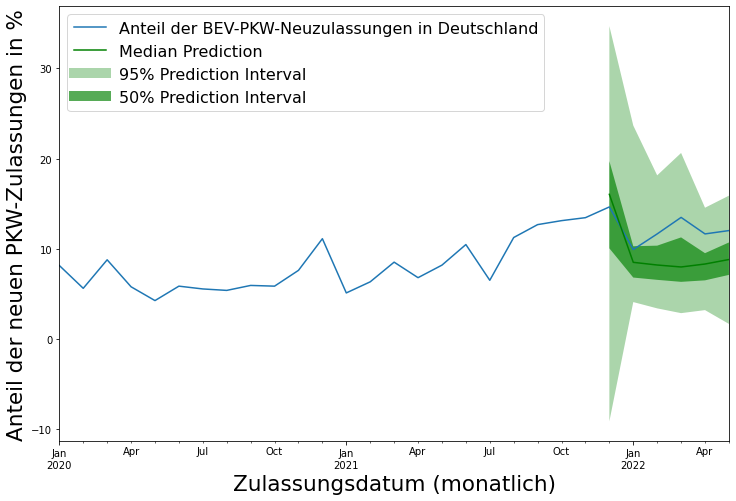

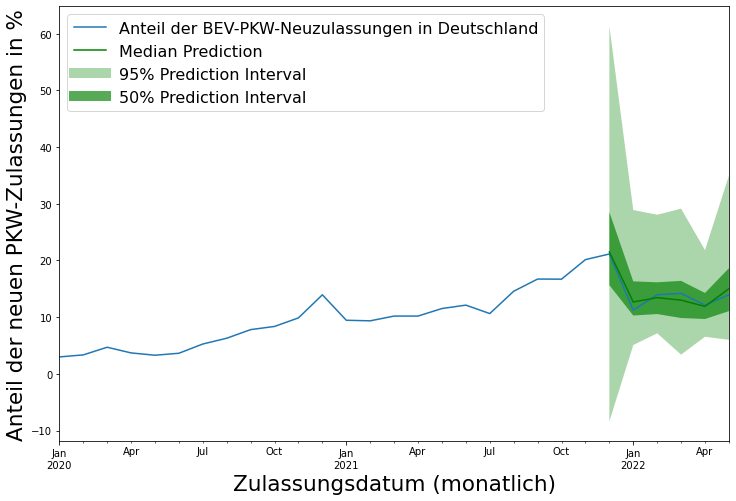

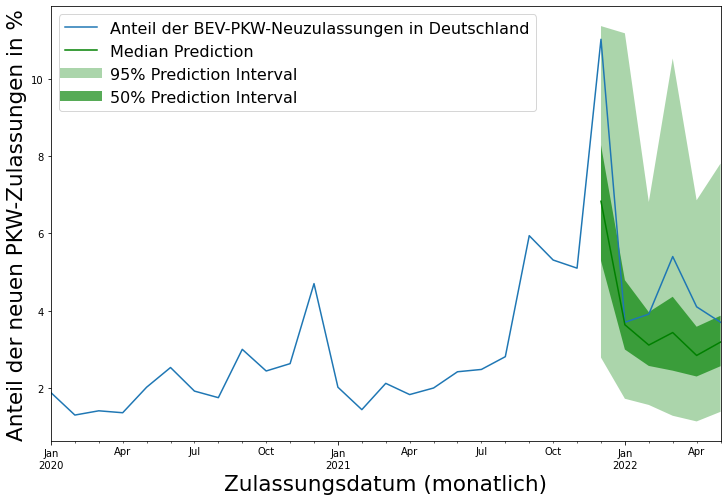

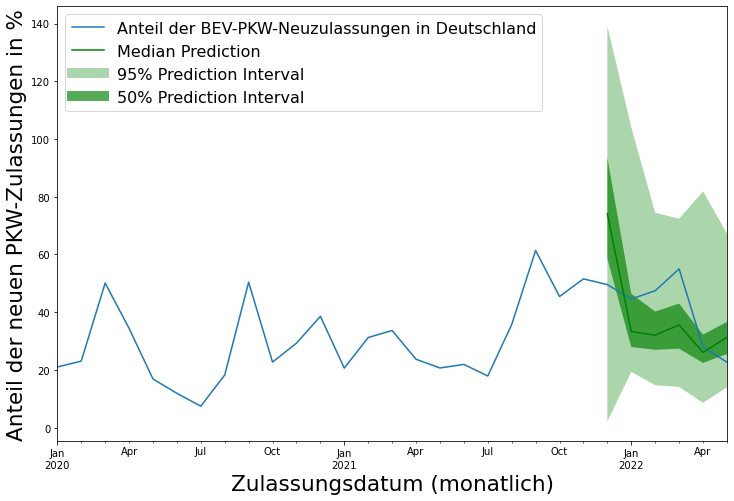

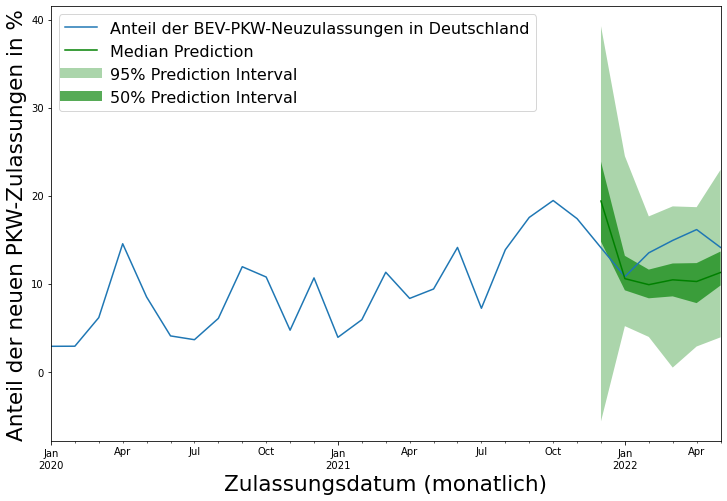

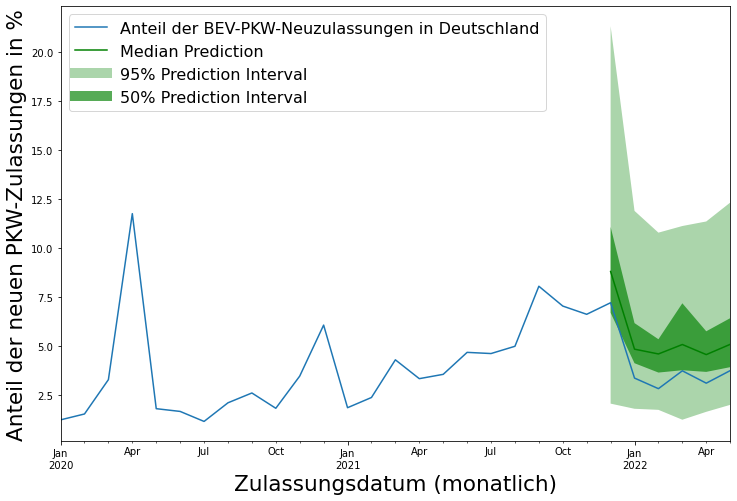

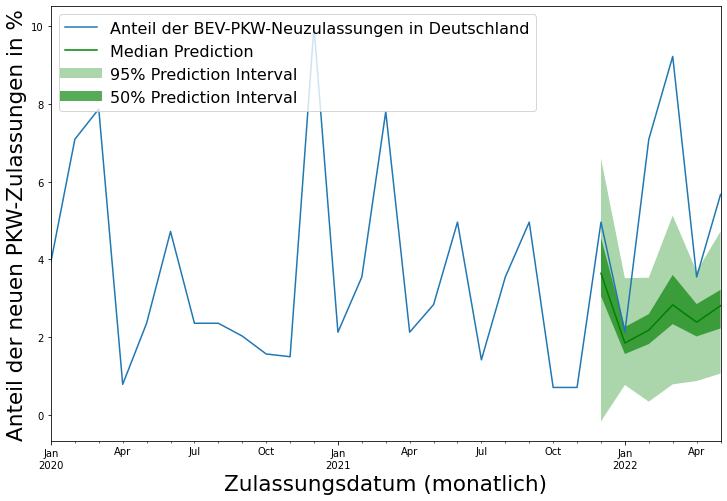

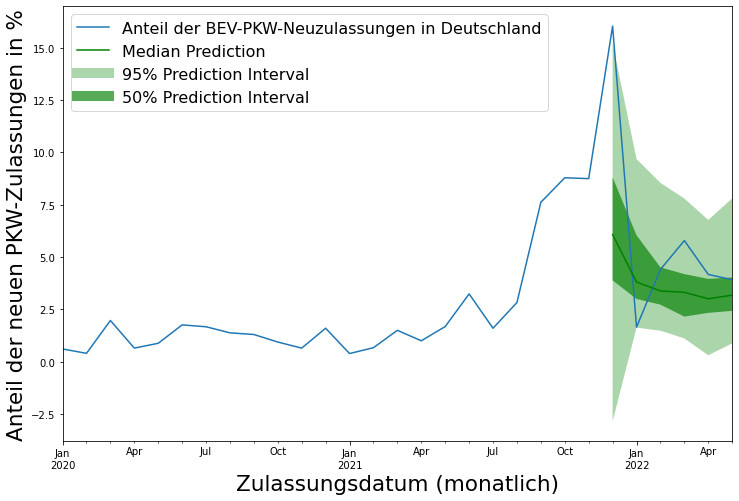

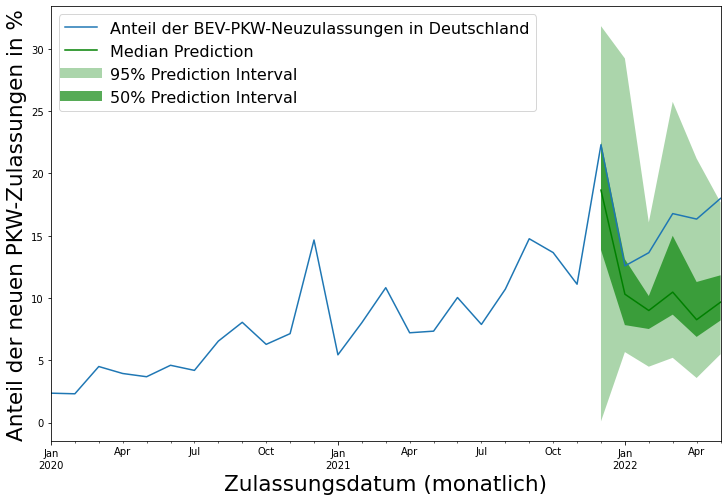

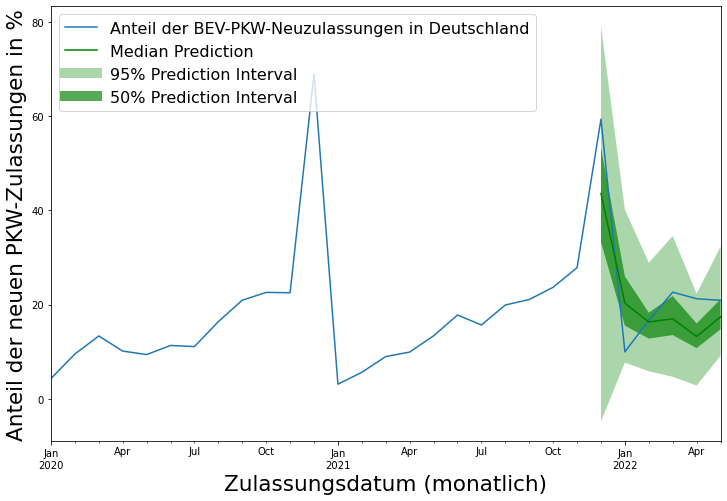

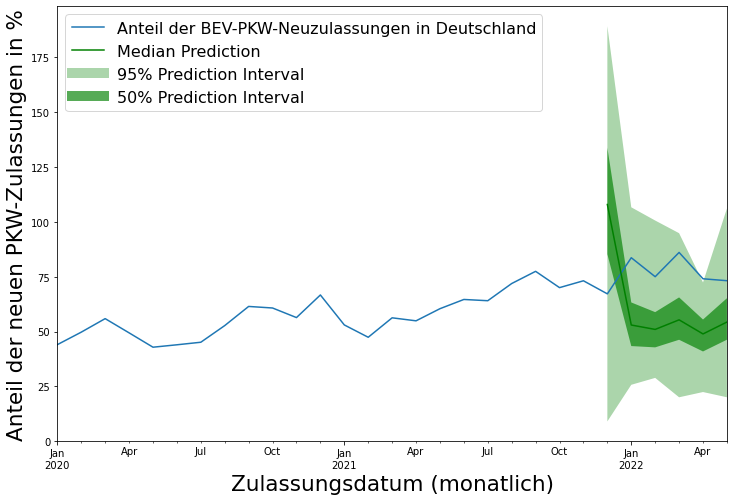

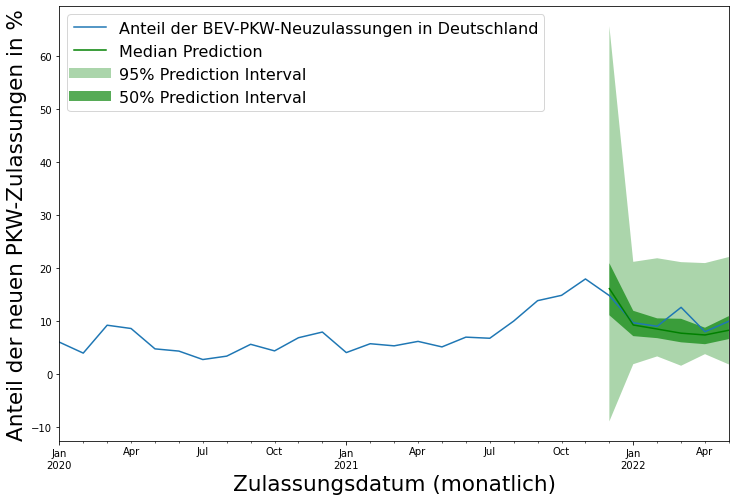

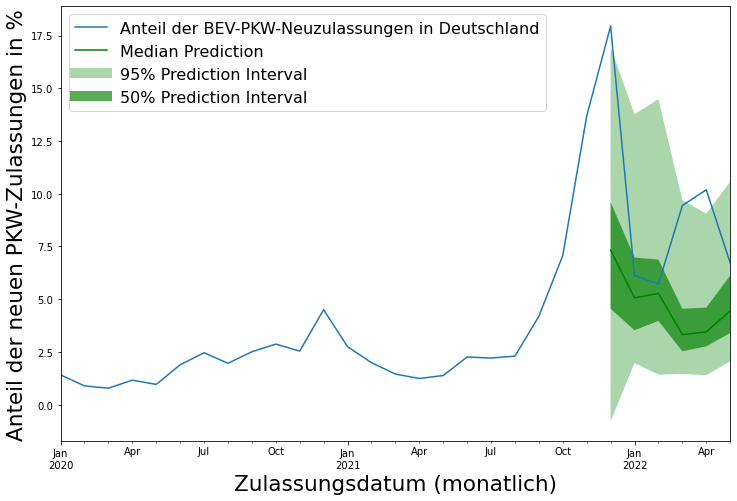

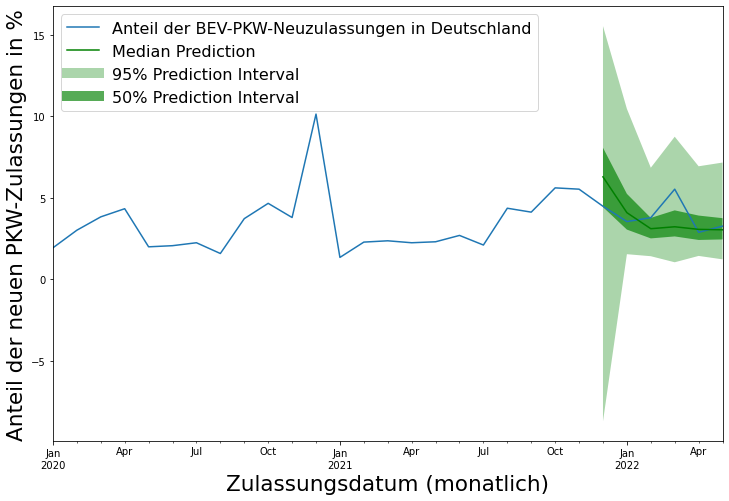

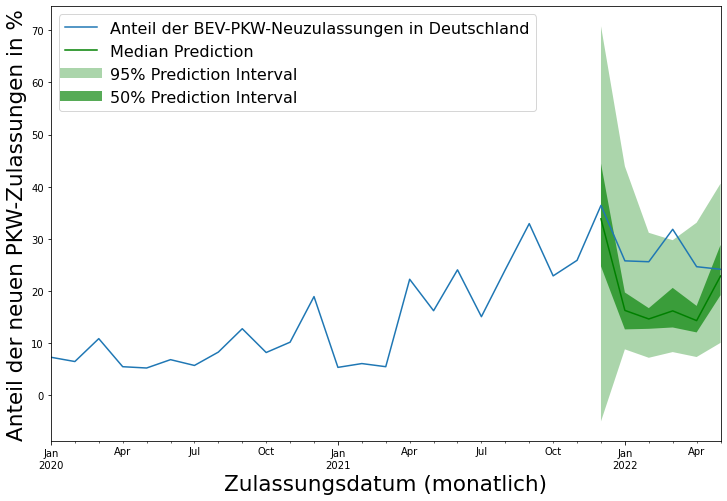

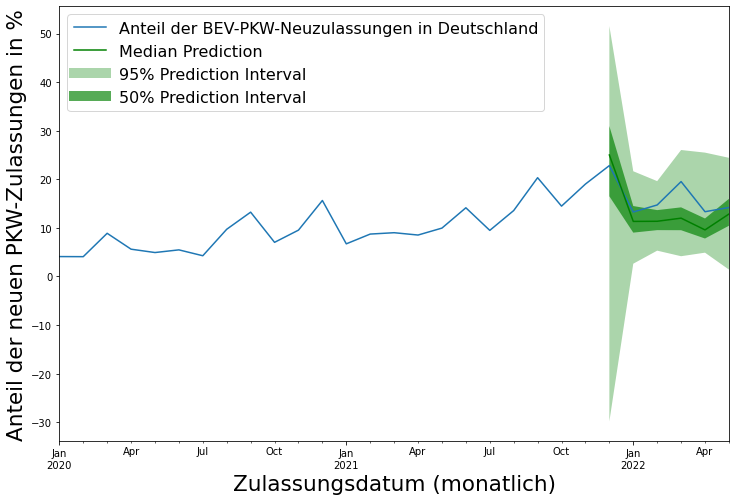

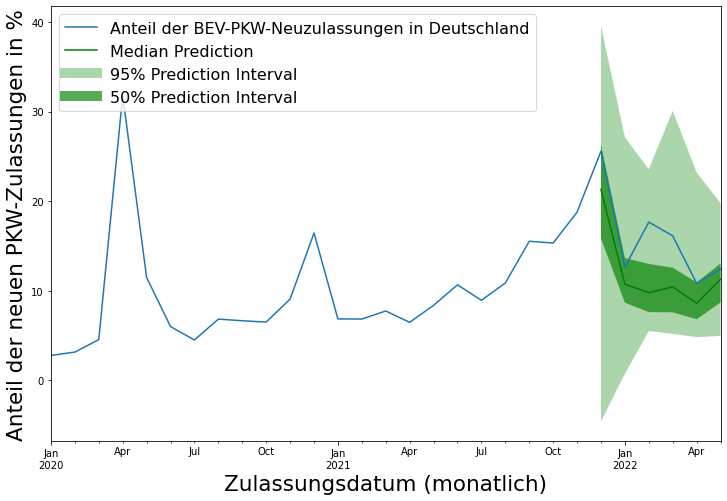

In [66]:
# Method 2: To visualize the forecasted values vs. observation (actual values) with confidence interval.
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                       # Maximum num of time points to plot. e.g. 66 time points (months)
    prediction_intervals = (50, 95)                     # Prediction interval to plot
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles
    
    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry.plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")
    plt.show()

# Visualizing results for all countries
for i in range(21):
    plot_prob_forecasts(tss[i], forecasts[i])


#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])      # In case if we set a 2nd Time step for evaluation in test_data

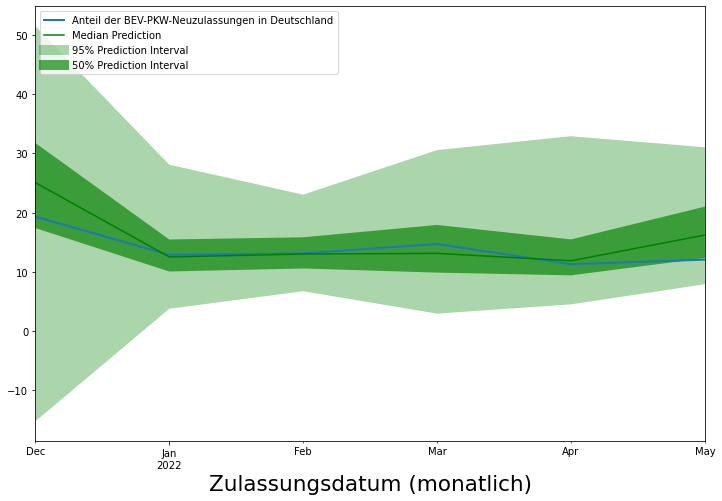

In [67]:
# Visualisation of Test-Dataset vs. Predicted Values.
def plot_forecasts(tss, forecasts, past_length, num_plots):
    prediction_intervals = (50, 95)                     # Prediction interval to plot
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles

    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 8), linewidth=2)
        forecast.plot(prediction_intervals, color='g')
        plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
        #plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
        #plt.grid(which='both')
        plt.legend(legend, loc="upper left")

        
# We already defined "ts_entry = tss[5]" and "forecast_entry = forecasts[5]"
# This mean, we have the values for Germany sepecified already.
plot_forecasts(tss,                 # Time Series Data
               forecasts,           # Forecast values
               past_length =6,      # Number of Months to show in Plot
               num_plots = 1)       # Number of Plots to show e.g. if we had many products to plot their forecasts.

## Error Metrics

We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [68]:
# creating evaluation instance with 50. Quantile
evaluator = Evaluator(quantiles=[0.5, 0.9])
# As default DeepAR outputs two metrics: Aggregated Metrics for all forecasts and Item Metrics for each individual product forecast
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 59.51it/s]


In [69]:
# Outputs Intem Metrics.
# As we have only one item "Batterielektrisch" due to Univariate analysis, therefore we see only one row of metrices.
item_metrics

item_id         MSE   abs_error  abs_target_sum  abs_target_mean  \
0       NaN   11.173171   12.534790       83.430000        13.905000   
1       NaN    8.601124   18.257057       58.209999         9.701667   
2       NaN   27.456680   35.964226      108.880005        18.146667   
3       NaN   20.996601   27.216852       90.209991        15.034999   
4       NaN    7.998689   18.300728       73.419998        12.236666   
5       NaN    2.179704    4.792683       86.599991        14.433332   
6       NaN    3.509104    8.789737       31.830002         5.305000   
7       NaN  201.428243   81.141090      247.179993        41.196665   
8       NaN   15.744525   22.369251       83.529999        13.921666   
9       NaN    3.622606    8.970135       24.070002         4.011667   
10      NaN   12.493416   16.909290       32.620003         5.436667   
11      NaN   18.544450   17.525745       35.979996         5.996666   
12      NaN   27.201065   33.277042       99.649994        16.608332   
13      NaN   81.878504   43.635632      150.800003        25.133334   
14      NaN  790.621908  170.231262      459.140015        76.523336   
15      NaN    4.357978    9.436213       64.410004        10.735001   
16      NaN   31.754140   27.276777       56.150002         9.358334   
17      NaN    1.008020    5.745297       23.469999         3.911667   
18      NaN   76.619629   50.298367      168.509995        28.084999   
19      NaN   10.753854   20.091433       97.870003        16.311667   
20      NaN   16.747318   23.103115       95.230003        15.871667   

    seasonal_error      MASE      MAPE     sMAPE        ND       MSIS  \
0         8.044545  0.259695  0.139489  0.125537  0.150243   3.863857   
1         2.542727  1.196685  0.320819  0.388529  0.313641   4.727464   
2         5.997273  0.999461  0.339706  0.412969  0.330311   4.608969   
3         6.120000  0.741200  0.289013  0.348395  0.301706   3.965638   
4         3.657273  0.833988  0.248990  0.290809  0.249261   5.534408   
5         7.491818  0.106620  0.060078  0.059071  0.055343   4.103965   
6         1.044545  1.402482  0.235227  0.278495  0.276146   7.126521   
7        12.136362  1.114297  0.312162  0.315250  0.328267   6.403685   
8         5.880000  0.634049  0.255520  0.278760  0.267799   3.715468   
9         3.252728  0.459621  0.409935  0.335905  0.372669   3.496580   
10        1.290000  2.184663  0.435449  0.604950  0.518372  47.491114   
11        2.489091  1.173504  0.509505  0.505217  0.487097   5.775527   
12        4.854546  1.142470  0.336246  0.418090  0.333939   4.471258   
13        3.159091  2.302120  0.353028  0.324035  0.289361  11.177624   
14       12.328180  2.301384  0.374745  0.406021  0.370761   8.256882   
15        4.860000  0.323601  0.136517  0.154756  0.146502   5.806575   
16        1.962727  2.316231  0.415465  0.578075  0.485784  12.940008   
17        1.075455  0.890367  0.214388  0.222653  0.244793   8.957074   
18       11.669091  0.718399  0.305055  0.384172  0.298489   4.227574   
19        5.189091  0.645310  0.205099  0.234922  0.205287   5.785688   
20        7.265454  0.529976  0.235599  0.278775  0.242603   3.364767   

    QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  Coverage[0.9]  
0           12.534790       0.500000          14.091781       1.000000  
1           18.257059       0.000000           6.871712       0.500000  
2           35.964225       0.000000           7.904126       0.333333  
3           27.216852       0.000000           5.575624       0.833333  
4           18.300729       0.166667           4.143331       1.000000  
5            4.792683       0.500000          10.056187       1.000000  
6            8.789737       0.000000           2.994715       0.833333  
7           81.141090       0.333333          28.069957       0.833333  
8           22.369250       0.166667           8.008517       0.666667  
9            8.970135       1.000000           6.098755       1.000000  
10       

In [70]:
# Checking RMSE value for Germany
rmse = np.sqrt(item_metrics.MSE[5])
rmse

1.4763819669934264

# Hyperparameter Optimization (HPO)
## Grid Search:

This grid search will go through **10800 Models** and returns a DataFrame of all models with used parameters.

**Warning:** Before running this code block please keep in mind that it will last around 4 days to be finished (90 Hours). For convenience, you can find the CSV-File of the executed Grid Search Result.

In [ ]:
# Hyperparameter Tuning: Grid Search
start_time = time.time()    # Keep record of time HPO takes

def deepar_gridearch(training_data, test_data=test_data, prediction_length=6, context_length=20, freq="M"):
    '''
    training_data: Training Dataset to be used for grid search
    context_length: Length of last periods to be used for forecasting and prediction_length
    prediction_length: Num of time points to be predicted.
    freq: Data frequency
    test_data: Test Dataset to used for model evaluation
    '''

    results = []

    for epochs in [5,10,15,20,25]:                                          # Num of epeochs
        for num_batche_per_epoch in [5,10,15,20,25,30]:                    # Num of batch per epoch
            for batch_size in [5,10,20,30]:                                # Batch size per epoch
                for num_layers in [2,5,8,10,15,20,22,25,27,30]:            # Num of layers in RNN
                    for num_cells in [2,3,4,5,10,15,20,30,40]:             # Num of Cells in RNN
                        try:
                            mx.random.seed(7)               # Setting seed to avoid getting random prediction values
                            np.random.seed(7)               # Setting seed to avoid getting random prediction values
                            estimator = DeepAREstimator(
                                context_length = context_length,
                                prediction_length=prediction_length,
                                freq=freq,
                                use_feat_static_cat=True,
                                cardinality=[1],
                                num_layers = num_layers,
                                num_cells = num_cells,
                                dropout_rate=0.02,
                                trainer=Trainer(epochs=epochs,
                                                num_batches_per_epoch=num_batche_per_epoch,
                                                batch_size=batch_size,
                                                learning_rate=0.001,
                                    #            callbacks=[             # These parameters are commented. See DeepAR Model Training
                                    #               ModelAveraging(avg_strategy=SelectNBestMean(num_models=2)),
                                    #              LearningRateReduction(base_lr=1e-3,
                                    #                                   decay_factor=0.5,
                                        #                                  patience=5,
                                        #                                 min_lr=0.0005, # minimum_learning_rate
                                        #                                objective="min")|
                                                )
                                )
                            # Executing the DeepAR Model trainng
                            predictor = estimator.train(training_data=training_data, num_workers=None, cache_data=True)
                            # Model Evaluation
                            forecast_it, ts_it = make_evaluation_predictions(dataset=test_data, predictor=predictor, num_samples=6)
                            # Error Metric
                            evaluator = Evaluator(quantiles=[0.5, 0.9])
                            agg_metrics, item_metrics = evaluator(iter(list(ts_it)), iter(list(forecast_it)), num_series=len(test_data))
                            # RMSE Error
                            rmse = np.sqrt(item_metrics.MSE[5])
                            # Putting together used Model Params to "results" list.
                            result = [epochs, num_batche_per_epoch, batch_size, num_layers, num_cells, round(rmse, 3)]
                            # To show progress: Printing currently used params in Model Training
                            print(f'\n{len(results)+1}  of  10800 Models – Combination:\t{result}')
                            # Appending used Model Params to "results" list.
                            results.append(result)
                        except:
                            continue
    # Creating a DataFrame our of "results" list
    results_df = pd.DataFrame(results, columns=['Epochs', 'num_batches_per_epoch', 'batch_size', 'Num_Layers', 'Num_Cells', 'RMSE'])
    # Soreting DataFrame values according to RMSE values
    results_df = results_df.sort_values(by=['RMSE'], ascending=True)
    # Returning Grid Search result as a DataFrame
    return results_df
# Applying the Grid Search Function
deepar_gridsearch_results = deepar_gridearch(training_data, test_data=test_data, context_length=20, prediction_length=6, freq="M")
# Saving the Grid Search as a CSV-File
deepar_gridsearch_results.to_csv('Path/To/Dataset/01_DeepAR_gridsearch_RMSE_6MonthsForecast_V1.csv')
# Checking the amount of time it took for DeepAR-Gridsearch
print(f"\nTime spent for DeepAR grid search (Minutes):\t{round((time.time() - start_time)/60, 2)}")          

deepar_gridsearch_results

Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 126.15it/s]



10799  of  10800 Models – Combination:	[25, 30, 30, 30, 30, 3.666]


Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 132.23it/s]



10800  of  10800 Models – Combination:	[25, 30, 30, 30, 40, 8.922]

Time spent for DeepAR grid search (Minutes):	5942.35


Epochs  num_batches_per_epoch  batch_size  Num_Layers  Num_Cells  \
10023      25                     20          30          10         20   
8557       20                     30          30           2         30   
9322       25                     10          30          20         30   
8205       20                     25          30           5         20   
9656       25                     15          30           8         40   
...       ...                    ...         ...         ...        ...   
9088       25                     10           5          30         30   
3536       10                     20          30           8         40   
207         5                      5          20          10          2   
5886       15                     25          10          15          2   
2956       10                     15           5          27         10   

         RMSE  
10023   0.802  
8557    0.879  
9322    0.896  
8205    0.898  
9656    0.953  
...       ...  
9088   29.573  
3536   30.433  
207    31.412  
5886   40.975  
2956   89.128  

[10800 rows x 6 columns]

## Optuna HPO

Optuna has 2 parts:

   * **Objective function:** To define which params and how the model should be trained as well as based on which error metric should Optuna optimize all process.
   * **Trail:** To specify how many times optuna should run to find the best parameter-combination for DeepAR Model.

In [24]:
# Optuna's Objective Function:

class DeepARTuningObjective:
    def __init__(self, training_data=training_data, test_data=test_data, prediction_length=6):
        """
            Dataset: Dataset
            prediction_length: Length of prediction horizon
            freq: Data Frequency
            metric_type: Type error metric for model evaluation
        """

        self.prediction_length = prediction_length
        self.training_dataset = training_data                                       # Sepecifying Training Dataset
        self.test_dataset = test_data                                               # Specifiying Test Dataset

    """
    get_params() Function: Sets types and size of all parameters for HPO process with Optuna:
         trial.suggest_int():           Used for params that take integers values.
         trial.suggest_float():         Used for params that take float values.
         trial.suggest_categorical()    Used for params that take categorical values.
    """
    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 2, 30),
            "num_cells": trial.suggest_int("num_cells", 2, 100),
            "dropout_rate": trial.suggest_float("dropout_rate", 0.00, 0.2),
            "epochs": trial.suggest_int("epochs", 5, 50),
            "batch_size": trial.suggest_int("batch_size", 5, 30),
            "num_batches_per_epoch": trial.suggest_int("num_batches_per_epoch", 5, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "context_length": trial.suggest_int("context_length", 2, 23),
        }

    """
    __call__() Function:
        Takes all the specified params,
        Uses splited datset,
        trains the DeepAR Model,
        then return the RMSE Error accordingly
    """
    def __call__(self, trial):
        params = self.get_params(trial)
        mx.random.seed(7)               # Setting seed to avoid getting random prediction values
        np.random.seed(7)               # Setting seed to avoid getting random prediction values
       
        estimator = DeepAREstimator(
            context_length=params["context_length"],
            freq = "M",
            prediction_length = self.prediction_length,
            use_feat_static_cat=True,
            cardinality=[1],
            num_layers = params["num_layers"],
            num_cells = params["num_cells"],
            cell_type = "lstm",
            dropout_rate = params["dropout_rate"],
            trainer = Trainer(
                epochs = params["epochs"],   
                batch_size = params["batch_size"],
                num_batches_per_epoch = params["num_batches_per_epoch"],
                learning_rate = params["learning_rate"],
    #            callbacks=[
     #               #ModelAveraging(avg_strategy=SelectNBestMean(num_models=1)),
      #              LearningRateReduction(
       #                 base_lr=1e-3,
        #                decay_factor=0.5,
         #               patience=6,
          #              min_lr=5e-5, # minimum_learning_rate
           #             objective="min")
            #    ],
            )
        )
        
        predictor = estimator.train(self.training_dataset, num_workers=None)      # Num of CPUs to 1 to avoid getting random values)
        forecast_it, ts_it = make_evaluation_predictions(dataset = test_data,       # Test dataset
                                                 predictor = predictor,             # Predictor/Fitted Model
                                                 num_samples = 100)                   # Number of sample paths we want for evaluation
                                                 
        forecasts = list(forecast_it)                                               # Forecasted Values
        tss = list(ts_it)                                                           # Time Series Data

        evaluator = Evaluator(quantiles=[0.5, 0.90]) 
        agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(self.test_dataset))
        
        # Returns RMSE item metric for Germany
        RMSE = np.sqrt(item_metrics.MSE[5])
        return RMSE        

Optuna's Execution for HPO:

In [58]:
start_time = time.time()    # Keep record of time HPO takes

# Make the sampler behave in a deterministic way.
sampler = TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, study_name='DeepAR Model (Multivariate Time Series Analysis)',         # Name for current Optuna HPO
                            direction="minimize"                                                                    # Purpose of Param-Tuning -> to minimize the Model-Error
                            )
study.optimize(
    DeepARTuningObjective(training_data=training_data, test_data=test_data, prediction_length=6),
                           n_trials=100)            # Num of Trails to search for
                           #n_jobs=2                # Num of CPUs to use. "-1" means use all CPU but won'T be optimal when exceting on cloud resources.


# Outputs num of Trails finished
print(f"Number of finished trials:\t{len(study.trials)}")
# Shows best trail value
trial = study.best_trial
print(f"\nBest trial's Value:\t\t{trial.value}")
# Shows params used for best trials
print("\nParams: ")
for key, value in trial.params.items():
    print(f" {key}:\t{value}")
# Shows time spent for current Optuna HPO Proces (in minutes)
print(f"\nTime spent for for HPO with Optuna (Minutes):\t{round((time.time() - start_time)/60, 2)}")                        

Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 72.35it/s]
[I 2022-11-10 14:30:16,023] Trial 80 finished with value: 110.83131655433255 and parameters: {'num_layers': 23, 'num_cells': 83, 'dropout_rate': 0.15282615227459734, 'epochs': 27, 'batch_size': 21, 'num_batches_per_epoch': 20, 'learning_rate': 0.086348462894665, 'context_length': 13}. Best is trial 11 with value: 1.4763819669934264.
Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 85.61it/s]
[I 2022-11-10 14:31:11,188] Trial 81 finished with value: 4.385886607357845 and parameters: {'num_layers': 4, 'num_cells': 32, 'dropout_rate': 0.10375668709488971, 'epochs': 49, 'batch_size': 18, 'num_batches_per_epoch': 28, 'learning_rate': 0.08273265292176346, 'context_length': 12}. Best is trial 11 with value: 1.4763819669934264.
Running evaluation: 100%|██████████| 21/21 [00:00<00:00, 83.05it/s]
[I 2022-11-10 14:31:48,534] Trial 82 finished with value: 3.6667226151330463 and parameters: {'num_layers': 4, 'num_cells': 26

Number of finished trials:	100

Best trial's Value:		1.4763819669934264

Params: 
 num_layers:	23
 num_cells:	2
 dropout_rate:	0.1122435424261366
 epochs:	50
 batch_size:	10
 num_batches_per_epoch:	14
 learning_rate:	0.09685043383629997
 context_length:	19

Time spent for for HPO with Optuna (Minutes):	227.64


In [ ]:
#trial.params

#### Saving Optuna HPO Study

In [ ]:
# Saving Optuna HPO Study
joblib.dump(study, "Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")

# To Load Optuna Study
#study = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
#print(f"Number of finished trials:\t{len(study.trials)}")
#trial = study.best_trial
#print(f"\nBest trial's Value:\t\t{trial.value}")
#print("\nParams: ")
#for key, value in trial.params.items():
#    print(f" {key}:\t{value}")

Optuna provides nice visualisation for each study (HPO Process with Optuna). To visualise each of these functionalites, we need import Optuna based Plotting Methods:

In [100]:
# Returns Optuna's Tuning results as a DataFrame
optuna_result = study.trials_dataframe()
optuna_result

number      value             datetime_start          datetime_complete  \
0        0   2.073970 2022-11-10 10:51:50.393964 2022-11-10 10:53:07.945927   
1        1   1.809760 2022-11-10 10:53:07.947705 2022-11-10 10:53:54.191512   
2        2   5.631642 2022-11-10 10:53:54.214366 2022-11-10 10:55:07.264117   
3        3   6.024873 2022-11-10 10:55:07.265982 2022-11-10 10:57:33.438688   
4        4   4.321344 2022-11-10 10:57:33.440342 2022-11-10 10:59:37.927726   
..     ...        ...                        ...                        ...   
95      95  40.692382 2022-11-10 14:38:04.558888 2022-11-10 14:38:22.058997   
96      96   3.314350 2022-11-10 14:38:22.061595 2022-11-10 14:38:40.314082   
97      97   2.463740 2022-11-10 14:38:40.316082 2022-11-10 14:38:55.462404   
98      98   3.249552 2022-11-10 14:38:55.464522 2022-11-10 14:39:08.117223   
99      99   1.624665 2022-11-10 14:39:08.119397 2022-11-10 14:39:28.781728   

                 duration  params_batch_size  params_context_length  \
0  0 days 00:01:17.551963                 17                     18   
1  0 days 00:00:46.243807                  5                     15   
2  0 days 00:01:13.049751                 19                     16   
3  0 days 00:02:26.172706                 21                     13   
4  0 days 00:02:04.487384                  7                     15   
..                    ...                ...                    ...   
95 0 days 00:00:17.500109                 17                      5   
96 0 days 00:00:18.252487                 24                      9   
97 0 days 00:00:15.146322                 19                      8   
98 0 days 00:00:12.652701                 30                      3   
99 0 days 00:00:20.662331                 10                      7   

    params_dropout_rate  params_epochs  params_learning_rate  \
0              0.126730             39              0.020608   
1              0.137072             48              0.081449   
2              0.183555             37              0.037961   
3              0.123553             28              0.080717   
4              0.018092             18              0.005643   
..                  ...            ...                   ...   
95             0.143142              9              0.019946   
96             0.186514             11              0.011951   
97             0.156274             19              0.004750   
98             0.199496             10              0.023548   
99             0.166542             16              0.066437   

    params_num_batches_per_epoch  params_num_cells  params_num_layers  \
0                             10                 4                 24   
1                             18                10                  6   
2                              8                30                 22   
3                             20                44                 14   
4                             26                33                 28   
..                           ...               ...                ...   
95                             7                69                 24   
96                            10                 3                 27   
97                             6                12                 21   
98                            12                 5                 26   
99                             8                16                 28   

       state  
0   COMPLETE  
1   COMPLETE  
2   COMPLETE  
3   COMPLETE  
4   COMPLETE  
..       ...  
95  COMPLETE  
96  COMPLETE  
97  COMPLETE  
98  COMPLETE  
99  COMPLETE  

[100 rows x 14 columns]

In [101]:
# Sorting Optuna's results according to its values 
# This allows us to see all the lowest errors first
optuna_result = optuna_result.sort_values(by='value', ascending=True)
optuna_result.head()

number     value             datetime_start          datetime_complete  \
11      11  1.476382 2022-11-10 11:14:05.157202 2022-11-10 11:16:17.682080   
99      99  1.624665 2022-11-10 14:39:08.119397 2022-11-10 14:39:28.781728   
69      69  1.801293 2022-11-10 14:04:02.748712 2022-11-10 14:06:03.691585   
1        1  1.809760 2022-11-10 10:53:07.947705 2022-11-10 10:53:54.191512   
88      88  1.823186 2022-11-10 14:36:29.509356 2022-11-10 14:36:41.499201   

                 duration  params_batch_size  params_context_length  \
11 0 days 00:02:12.524878                 10                     19   
99 0 days 00:00:20.662331                 10                      7   
69 0 days 00:02:00.942873                  5                     13   
1  0 days 00:00:46.243807                  5                     15   
88 0 days 00:00:11.989845                 17                      8   

    params_dropout_rate  params_epochs  params_learning_rate  \
11             0.112244             50              0.096850   
99             0.166542             16              0.066437   
69             0.153903             31              0.057101   
1              0.137072             48              0.081449   
88             0.176296              7              0.008413   

    params_num_batches_per_epoch  params_num_cells  params_num_layers  \
11                            14                 2                 23   
99                             8                16                 28   
69                            16                16                 30   
1                             18                10                  6   
88                            10                12                 25   

       state  
11  COMPLETE  
99  COMPLETE  
69  COMPLETE  
1   COMPLETE  
88  COMPLETE

In [36]:
# Visualising the optimizsation history. It shows how (Optuna's) Error decreased over time.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_optimization_history.html#optuna.visualization.plot_optimization_history
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [37]:
# Visualize parameter importances
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_param_importances.html#optuna.visualization.plot_param_importances
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [38]:
# Check which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [105]:
# Visualize high-dimensional parameter relationships.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_parallel_coordinate.html#optuna.visualization.plot_parallel_coordinate
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [110]:
# Select 3 best parameters to visualize.
plot_parallel_coordinate(study, params=["num_cells", "context_length", "num_batches_per_epoch"])

In [111]:
# Visualize hyperparameter relationships
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html#optuna.visualization.plot_contour
from optuna.visualization import plot_contour
plot_contour(study)

In [113]:
# Visualize 2 best hyperparameter relationships
plot_contour(study, params=["num_cells", "num_batches_per_epoch"])

In [114]:
# Visualize individual hyperparameters as slice plot.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html#optuna.visualization.plot_slice
from optuna.visualization import plot_slice
plot_slice(study)

In [116]:
# Select 3 best parameters to visualize as slice plot.
plot_slice(study, params=["num_cells", "context_length", "num_batches_per_epoch"])

In [117]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
plot_edf(study)

In [ ]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
study_sarima = joblib.load("Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
study_sarima.study_name='SARIMA Model'
study_sarimax = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
study_sarimax.study_name='SARIMAX Model'
study_deepAR_univariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V1.pkl")
study_deepAR_univariate_tsa.study_name='DeepAR Model (Univariate)'
study_deepAR_multivariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
study_deepAR_multivariate_tsa.study_name='DeepAR Model (Multivariate)'

plot_edf([study_sarima, study_sarimax, study_deepAR_univariate_tsa, study_deepAR_multivariate_tsa])

# Re-Train Model on full dataset

In [27]:
freq = "M"                                              # Data frequency – "M" means monthly dataset
prediction_length = 6                                   # Number of future values to be forecasted. It's the prediction length of time series – This can not be changed once the model is trained

start_train = pd.Timestamp("2020-01-01", freq=freq)     # Starting date of the training-dataset


# Creating a complete Dataset consisting all input dataset
training_data_full = ListDataset([
    {
        FieldName.TARGET: target,                       # Data values of countries (time series) for Training
        FieldName.START: start_train,                   # Starting Date in Training Dataset
        FieldName.FEAT_STATIC_CAT: fsc,                 # Categorical values
    }
    for (target, fsc) in zip(df_input.iloc[:,1:].values,
                             country_code.reshape(-1,1))
], freq=freq)                                           # Data Frequency – For Monthly Data it is always "M"


mx.random.seed(7)                                       # Setting seed to avoid getting random prediction values
np.random.seed(7)                                       # Setting seed to avoid getting random prediction values

# Execution of DeepAR Model Training
predictor = estimator.train(training_data=training_data_full, num_workers=None)      # Num of CPUs to 1 to avoid getting random values

# Forecasting to future
After training the DeepAR Model, we can start forcasting to the future.

Basically, DeepAR won't predict more than 6 months because we set "prediction_length = 6"


In [28]:
prediction_intervals = (50,80,95)
def plot_future_forecasts(ts_entry, forecast_entry, prediction_intervals=prediction_intervals):
    plot_length = 100                                       # Maximum num of time points to plot. e.g. 66 time points (months)
    prediction_intervals = prediction_intervals                    # Prediction interval to plot
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles
    
    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry.plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")
    plt.show()


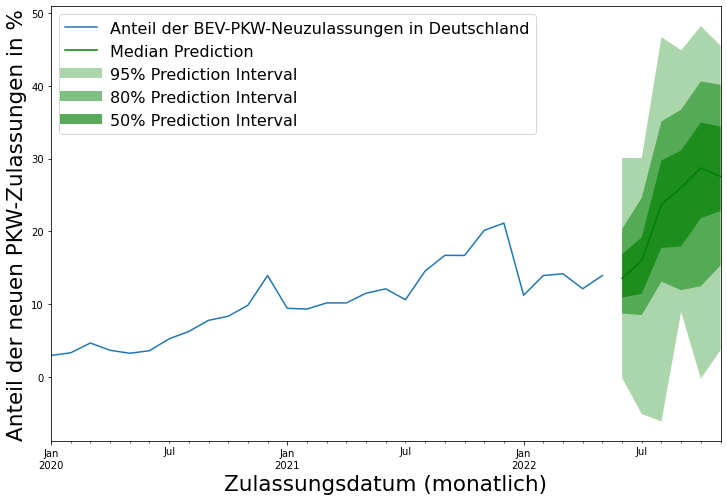

In [29]:
# We create an instance of variable so that the predict method can forcast from that time.
# Now using "predict" method to forecast the specified time frame.
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values

predict_6months_all_countries = predictor.predict(training_data_full)

# In DeepAR, it is not straigth foreward to get the predicted values. 
# Thus, we need to convert it to a list (Multi-Arrays) first.
forecast_6months_all_countries_list = list(predict_6months_all_countries)

# Getting the values of the list
# [5] means Germany due to array indexing in DeepAR prediction in "forecast_6months_all_countries_list"
predict_6months_germany = forecast_6months_all_countries_list[5]   


# Specify the desired confidence interval
plot_future_forecasts(df.Germany, predict_6months_germany)

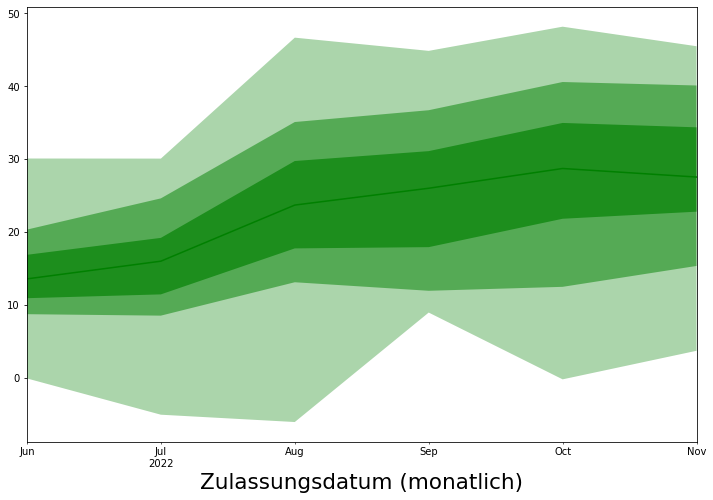

In [30]:
plt.figure(figsize=(12,8))
predict_6months_germany.plot(prediction_intervals=prediction_intervals, color="green")
prediction_intervals = (50,80,95)                    # Prediction interval to plot
#legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
#    f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles
plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
#plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
#plt.grid()
#plt.legend(legend,loc="upper left")
plt.show()

### Generate Forecasts for Germany

In [93]:
# Converting the predicted 6 months to DataFrame consisting 95% confidence interval
df_future_6months_germany_CI_95 = pd.DataFrame({'Median Value':predict_6months_germany.median, 'Lower Bound 95%_CI':predict_6months_germany.quantile(0.025), 'Upper Bound 95%_CI':predict_6months_germany.quantile(0.975), 'Lower Bound 80%_CI':predict_6months_germany.quantile(0.10), 'Upper Bound 80%_CI':predict_6months_germany.quantile(0.90),'Lower Bound 50%_CI':predict_6months_germany.quantile(0.25), 'Upper Bound 50%_CI':predict_6months_germany.quantile(0.75)}, index=pd.date_range(start="2022-06-01", periods=prediction_length, freq="MS"))
df_future_6months_germany_CI_95.to_csv("Path/To/Dataset/Prediction_6Months_DeepAR_Model_Germany_Conf_Interval.csv")
df_future_6months_germany_CI_95

Median Value  Lower Bound 95%_CI  Upper Bound 95%_CI  \
2022-06-01     13.570778           -0.092037           30.090235   
2022-07-01     15.999824           -5.069271           30.077646   
2022-08-01     23.700924           -6.074854           46.675545   
2022-09-01     26.009052            8.948547           44.863506   
2022-10-01     28.720558           -0.217594           48.180737   
2022-11-01     27.546259            3.703707           45.499161   

            Lower Bound 80%_CI  Upper Bound 80%_CI  Lower Bound 50%_CI  \
2022-06-01            8.725856           20.333040           10.920323   
2022-07-01            8.526443           24.618578           11.444610   
2022-08-01           13.108845           35.096615           17.754852   
2022-09-01           11.937818           36.716671           17.927004   
2022-10-01           12.479276           40.588245           21.822239   
2022-11-01           15.346983           40.111343           22.793276   

            Upper Bound 50%_CI  
2022-06-01           16.873777  
2022-07-01           19.197929  
2022-08-01           29.745615  
2022-09-01           31.102413  
2022-10-01           34.970654  
2022-11-01           34.368958

### Forecasts for All Countries

In [94]:
# Extract Cofidence Interval for all countries (90%, 80%, 50%)
# Sepecifying list of country names

country_names=df.columns.values
# Creating an emtpy DataFrame with date range
df_countries_confidence_interval=pd.DataFrame(index=pd.date_range(start="2022-06-01", periods=prediction_length, freq="MS"))
# Adding name to the index column of DataFrame
df_countries_confidence_interval.index.name = 'Date'

# Looping through all forecasted values (Multi-Array of DeepAR) and 
# extracting confidence interval for each country
for country in range(len(country_names)):
    forecast_6months_i_only = forecast_6months_all_countries_list[country]
    df_countries_confidence_interval[country_names[country]+"_Median"] = forecast_6months_i_only.median
    df_countries_confidence_interval[country_names[country]+"_95%CI_Lower_Bound"] = forecast_6months_i_only.quantile(0.025)            # Lower bound 5%
    df_countries_confidence_interval[country_names[country]+"_95%CI_Upper_Bound"] = forecast_6months_i_only.quantile(0.975)           # Upper bound 95%
    df_countries_confidence_interval[country_names[country]+"_80%CI_Lower_Bound"] = forecast_6months_i_only.quantile(0.10)           # Lower bound 25%
    df_countries_confidence_interval[country_names[country]+"_80%CI_Upper_Bound"] = forecast_6months_i_only.quantile(0.90)           # Upper bound 75%
    df_countries_confidence_interval[country_names[country]+"_50%CI_Lower_Bound"] = forecast_6months_i_only.quantile(0.25)           # Lower bound 25%
    df_countries_confidence_interval[country_names[country]+"_50%CI_Upper_Bound"] = forecast_6months_i_only.quantile(0.75)           # Upper bound 75%

#df_countries_confidence_interval.to_csv("Path/To/Dataset/Prediction_all_countries_conf_interval.csv")
df_countries_confidence_interval


Austria_Median  Austria_95%CI_Lower_Bound  \
Date                                                    
2022-06-01       13.827949                   4.250185   
2022-07-01       15.091370                  -0.673479   
2022-08-01       22.419807                   4.700912   
2022-09-01       28.738794                   4.318679   
2022-10-01       29.056383                  -0.453540   
2022-11-01       28.650576                   5.204346   

            Austria_95%CI_Upper_Bound  Austria_80%CI_Lower_Bound  \
Date                                                               
2022-06-01                  27.524681                   9.198868   
2022-07-01                  29.343676                   4.776897   
2022-08-01                  54.825497                  11.934602   
2022-09-01                  54.028751                  13.507365   
2022-10-01                  49.755569                   8.454596   
2022-11-01                  60.343746                  14.305582   

            Austria_80%CI_Upper_Bound  Austria_50%CI_Lower_Bound  \
Date                                                               
2022-06-01                  18.460379                  11.402492   
2022-07-01                  22.640926                  11.328152   
2022-08-01                  33.790386                  16.137657   
2022-09-01                  38.422188                  20.047039   
2022-10-01                  40.945877                  21.287521   
2022-11-01                  41.626423                  21.413143   

            Austria_50%CI_Upper_Bound  Belgium_Median  \
Date                                                    
2022-06-01                  16.070604        9.535457   
2022-07-01                  18.700285        8.830624   
2022-08-01                  26.841459       12.662699   
2022-09-01                  32.091232       14.117208   
2022-10-01                  33.843128       13.726485   
2022-11-01                  34.343323       13.805364   

            Belgium_95%CI_Lower_Bound  Belgium_95%CI_Upper_Bound  ...  \
Date                                                              ...   
2022-06-01                  -1.586866                  16.564188  ...   
2022-07-01                   0.188412                  22.302759  ...   
2022-08-01                  -0.896316                  33.248192  ...   
2022-09-01                   0.548739                  34.076878  ...   
2022-10-01                   1.255687                  32.442326  ...   
2022-11-01                   2.272058                  22.050499  ...   

            Switzerland_80%CI_Upper_Bound  Switzerland_50%CI_Lower_Bound  \
Date                                                                       
2022-06-01                      23.915472                      12.672150   
2022-07-01                      23.484806                      10.999778   
2022-08-01                      38.815735                      20.783909   
2022-09-01                      36.283756                      19.638889   
2022-10-01                      37.254719                      15.119959   
2022-11-01                      41.900803                      23.406614   

            Switzerland_50%CI_Upper_Bound  United Kingdom_Median  \
Date                                                               
2022-06-01                      19.751701              14.058249   
2022-07-01                      19.406940              12.880130   
2022-08-01                      31.918800              21.020313   
2022-09-01                      32.426296              22.464375   
2022-10-01                      31.355295              24.799412   
2022-11-01                      33.997993              27.196928   

            United Kingdom_95%CI_Lower_Bound  \
Date                                           
2022-06-01                         -0.042840   
2022-07-01                        -15.814912   
2022-08-01                          3.546831   
2022-09-01                   

In [95]:
# Extraction of pedian predicted values for all countries.
# sepecifying list of country names
country_names=df.columns.values
# Creating an emtpy DataFrame with date range
df_countries=pd.DataFrame(index=pd.date_range(start="2022-06-01", periods=prediction_length, freq="MS"))
# Adding name to the index column of DataFrame
df_countries.index.name = 'Date'

# Looping through all forecasted values (Multi-Array of DeepAR) and 
# extracting median prediction for each country
for country in range(len(country_names)):
    forecast_6months_i_only = forecast_6months_all_countries_list[country]
    df_countries[country_names[country]] = forecast_6months_i_only.median     # Median forecast

df_countries.to_csv("Path/To/Dataset/Prediction_all_21_countries_Median.csv")
df_countries


Austria    Belgium    Denmark    Finland     France    Germany  \
Date                                                                           
2022-06-01  13.827949   9.535457  16.540956  17.190397  13.401526  13.570778   
2022-07-01  15.091370   8.830624  15.736986  12.770144  12.426452  15.999824   
2022-08-01  22.419807  12.662699  28.895222  18.530813  17.407726  23.700924   
2022-09-01  28.738794  14.117208  24.789478  22.816378  19.743855  26.009052   
2022-10-01  29.056383  13.726485  26.092001  22.005190  20.616899  28.720558   
2022-11-01  28.650576  13.805364  28.898739  24.155310  21.404812  27.546259   

             Hungary    Iceland    Ireland     Italy  ...  Lithuania  \
Date                                                  ...              
2022-06-01  5.749101  31.140858  12.899504  5.292773  ...   5.412897   
2022-07-01  4.088818  30.798193  15.974180  5.647419  ...   3.165693   
2022-08-01  7.371247  53.097771  21.811113  7.697853  ...   6.560092   
2022-09-01  8.135965  67.604103  24.617113  9.269491  ...   8.585263   
2022-10-01  8.415578  61.401798  24.665947  9.469560  ...   8.390679   
2022-11-01  8.506242  78.422310  25.283937  9.657224  ...   8.467046   

            Luxembourg  Netherlands      Norway   Portugal    Romania  \
Date                                                                    
2022-06-01   20.319885    27.676537   82.670235  10.570914   6.637306   
2022-07-01   15.789952    20.190842   87.882942   8.882003   5.164269   
2022-08-01   20.716354    37.485744  109.045959  15.092532   7.072696   
2022-09-01   24.807846    43.473042  128.282898  20.356054  10.226993   
2022-10-01   22.946133    43.271358  124.664955  19.942305  10.293074   
2022-11-01   26.142254    45.752163  134.429626  20.392546  11.780413   

            Slovenia     Sweden  Switzerland  United Kingdom  
Date                                                          
2022-06-01  4.305456  27.575710    16.832323       14.058249  
2022-07-01  4.540646  24.247093    14.751642       12.880130  
2022-08-01  6.530873  37.941872    25.253782       21.020313  
2022-09-01  7.962101  41.651863    27.019558       22.464375  
2022-10-01  7.518704  40.510555    25.578493       24.799412  
2022-11-01  7.719920  45.076481    29.858723       27.196928  

[6 rows x 21 columns]

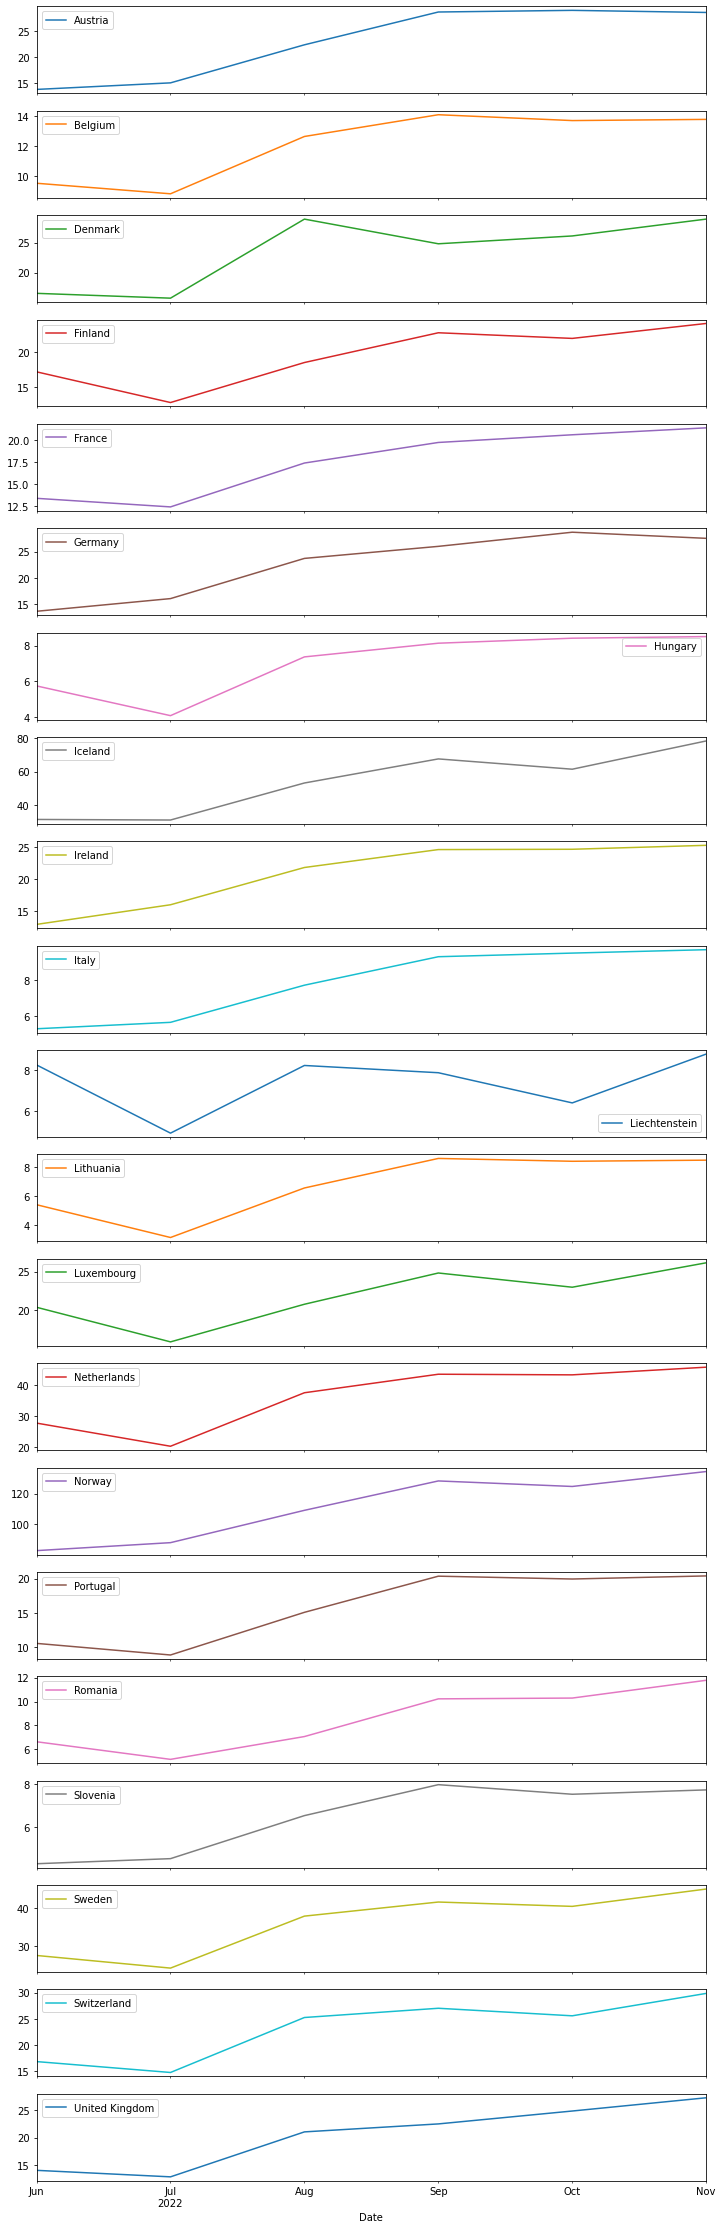

In [96]:
# Visualisation of 6 months forecasts for All Countries (Median Only)
df_countries.plot(figsize=(12,40), subplots=True)
plt.show()

In [97]:
# Visualisation of orignall dataset of All Countries
#df.plot(figsize=(14,40), subplots=True)
#plt.show()

# Saving & Loading Trained DeepAR Model

In [98]:
# Saving the trained DeepAR Model:
from pathlib import Path
predictor.serialize(Path("Path/To/Dataset/02_DeepAR/03_Saved_DeepAR_Models"))

In [24]:
# loads the trained DeepAR Model back:
#from gluonts.model.predictor import Predictor
#from pathlib import Path
#predictor_deserialized = Predictor.deserialize(Path("Path/To/Dataset/03_Saved_DeepAR_Models"))

<div class="alert alert-info"><h3>Conclusion:</h3>
This is the final version of DeepAR's Multivariate Time Series Analysis.<br><br>
</div>